In [1]:
import json
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd

In [15]:
def plot_percentiles_ratio(zerortt_time_difference, onertt_time_difference, output_file='0-rtt-percentiles-ratio.png'):
    """
    Plot the ratio of the percentiles of 0-RTT and 1-RTT.
    The x-axis should be the percentile, and the y-axis should be the ratio.
    """
    # get the percentiles of the time differences
    zerortt_percentiles = np.percentile(zerortt_time_difference, np.linspace(0, 99, 100))
    onertt_percentiles = np.percentile(onertt_time_difference, np.linspace(0, 99, 100))

    # get the ratio
    ratio = onertt_percentiles / zerortt_percentiles
    plt.subplots(figsize=(6, 2))
    # plot the ratio
    plt.plot(np.linspace(0, 99, 100), ratio)

    # set the title and labels
    plt.title('Ratio of percentiles')
    plt.xlabel('Percentile')
    plt.ylabel('1-RTT / 0-RTT')
    plt.ylim(0, 3)
    plt.grid()

    # save the plot
    plt.savefig(output_file)

    # show the plot
    plt.show()
    plt.cla()


def plot_boxplot(differences, labels, output_file='0-rtt-boxplot.png'):
    """
    Plot the boxplot of the time differences of 0-RTT and 1-RTT
    """
    # plot the boxplot
    plt.boxplot(differences, labels=labels)

    # set the title and labels
    plt.title('Boxplot of time difference between first packet sent and first packet received')
    plt.xlabel('Packet type')
    plt.ylabel('Time difference (ms)')
    plt.ylim(0, 10)
    # save the plot
    plt.savefig(output_file)

    # show the plot
    plt.show()
    plt.cla()


def plot_cdf(differences, labels, output_file='0-rtt-cdf.png'):
    """
    Plot the CDF of the time differences of 0-RTT and 1-RTT
    """
    # sort the time differences
    [difference.sort() for difference in differences]
    # zerortt_time_difference.sort()
    # onertt_time_difference.sort()

    # get the number of time differences
    lengths = [len(difference) for difference in differences]
    # num_zerortt = len(zerortt_time_difference)
    # num_onertt = len(onertt_time_difference)

    # get the x-axis values
    x_axis_values = [np.linspace(0, 1, length) for length in lengths]
    # zerortt_x = np.linspace(0, 1, num_zerortt)
    # onertt_x = np.linspace(0, 1, num_onertt)

    # plot the CDFs
    lines = ["-", "-.", "--", ":"]
    for i, difference in enumerate(differences):
        plt.plot(difference, x_axis_values[i], linestyle=lines[i % len(lines)], label=labels[i])

    # plt.plot(zerortt_time_difference, zerortt_x, linestyle='-', label='0-RTT')
    # plt.plot(onertt_time_difference, onertt_x, linestyle='-.', label='1-RTT')

    # set the title and labels
    # plt.title('CDF of time difference between first packet sent and first packet received')
    plt.xlabel('Time difference (ms)')
    plt.ylabel('CDF')
    plt.xlim(0, 10)

    # set the legend
    plt.legend()

    # save the plot
    plt.savefig(output_file)

    # show the plot
    plt.show()
    plt.cla()


def get_statistics(qlogs_folder):
    """
    go over the files in the qlogs folder (of extension .qlog),
    and for each file, read it as a json, and as a datapoint, store the
    difference between the time of the first packet sent and the time of the
    first packet received of type 1RTT.
    The packet type is under ["traces"][0]["events"][i]["packet_sent"]["packet_type"] and
    ["traces"][0]["events"][i]["packet_received"]["packet_type"], if the packet is sent or
    received.
    """
    # get all the files in the folder
    files = os.listdir(qlogs_folder)

    # store the time differences in a list
    time_differences = []

    for i, file in enumerate(files):
        # print("Reading file: " + file)
        # read the file as a json
        with open(qlogs_folder + '/' + file) as f:
            data = json.load(f)

        time_first_sent = None
        time_onertt_received = None
        # go over the events
        for event in data["traces"][0]["events"]:
            if "packet_sent" in event and time_first_sent is None:
                if "packet_type" in event[3]:
                    if event[3]["packet_type"] == "initial":
                        # get the time of the first initial packet sent by the client
                        time_first_sent = event[0]
            
            if "packet_received" in event and time_onertt_received is None:
                if "packet_type" in event[3]:
                    # if the packet is a 1RTT packet
                    if event[3]["packet_type"] == "1RTT":
                        # get the time of the first 1RTT packet received from the server
                        time_onertt_received = event[0]
        difference = int(time_onertt_received) - int(time_first_sent)
        assert difference > 0
        # store the time difference
        time_differences.append(difference)
        if i % 100000 == 0:
            print("Finished reading " + str(i) + " files")

    # get the mean and standard deviation of the time differences
    mean = np.mean(time_differences)
    std = np.std(time_differences)

    # print the statistics
    print("Mean: " + str(mean))
    print("Standard deviation: " + str(std))
    return time_differences


def get_values_from_file(filename):
    df = pd.read_csv(filename)
    zerortt_time_difference = df['0_rtt'].tolist()
    onertt_time_difference = df['1_rtt'].tolist()
    return zerortt_time_difference, onertt_time_difference


def get_values_from_qlogs(qlogs_folder, num_iterations):
    configurations = ['0_rtt', '1_rtt']
    min_length = 10000000
    statistics = {c: None for c in configurations}
    for configuration in configurations:
        folder = qlogs_folder + configuration
        print(configuration)
        stats = get_statistics(folder)
        statistics[configuration] = stats[-num_iterations:]
        min_length = min(min_length, len(statistics[configuration]))


    # qlogs_folder = './quic-lb-proxygen/parallel-P5-C0_rtt'
    # print("0-RTT")
    # zerortt_time_difference = get_statistics(qlogs_folder)

    # qlogs_folder = './quic-lb-proxygen/parallel-P5-C1_rtt'
    # print("1-RTT")
    # onertt_time_difference = get_statistics(qlogs_folder)

    # save the time differences to a file
    statistics = {c: statistics[c][:min_length] for c in configurations}
    df = pd.DataFrame(statistics)
    # df = pd.DataFrame({'0-RTT': zerortt_time_difference, '1-RTT': onertt_time_difference})
    print("saving results to csv")
    df.to_csv(f'{qlogs_folder}.csv', index=False)
    return statistics["0_rtt"], statistics["1_rtt"]

COLORS_DICT = {
    "0-RTT": ("#1f77b4", "\\\\"),
    "1-RTT": ("#ff7f0e", "//")
}

def get_y_values(differences, metric='mean'):
    """
    return a dictionary that the keys are the configuration (0-RTT or 1-RTT)
    and the values are dictionaries that the keys are the number of processes
    and the values are the metric for each iteration (a list)
    {
        0-RTT:
        {
            1: [1, 2, 3, 4, 5],
            5: [1, 2, 3, 4, 5],
            10: [1, 2, 3, 4, 5],
            ...
        },
        1-RTT: {...}
        }
    }
    """
    y_values = {config: {} for config in differences.keys()}
    for config in differences.keys():
        if metric == 'mean':
            # get the mean value for each iteration
            y_values[config] = {process_number: [np.mean(iteration) for iteration in iterations] for process_number, iterations in differences[config].items()}
        elif metric == 'median':
            y_values[config] = {process_number: [np.median(iteration) for iteration in iterations] for process_number, iterations in differences[config].items()}
        elif metric == 'p99':
            y_values[config] = {process_number: [np.percentile(iteration, 99) for iteration in iterations] for process_number, iterations in differences[config].items()}
    return y_values


def plot_all_mean_boxplot(y_values, output_file, metric):
    """
    for each difference in differences, calculate the given metric.
    plot the same plots as in plot_all_mean, but add a boxplot for each
    number of processes, by calculating the metric for each iteration
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=96)
    legend_elements = []
    for config in y_values.keys():
        x_axis_values = [int(process_number) for process_number in y_values[config].keys()]
        
        # plot the boxplot for each number of processes
        meanpointprops ={"marker":'o',"markersize":4,"markeredgecolor":"black", "markerfacecolor":"red"}
        boxprops = {"linestyle":"-.", "linewidth":2, "color":"black"}
        # bplot = ax.boxplot(y_values[config].values(), positions=x_axis_values, widths=6, showfliers=False, notch=False, patch_artist=True, showmeans=True, meanprops=meanpointprops, whis=(5,95))  # for latency results
        bplot = ax.boxplot(y_values[config].values(), positions=x_axis_values, widths=6, showfliers=False, notch=False, patch_artist=True, whis=(5,95))  # for perf results
        # bplot = ax.boxplot(y_values[config].values(), positions=x_axis_values, widths=4, showfliers=False, notch=False, patch_artist=True, showmeans=True)
        
        # color the boxplot
        # print(f"{ylabel} - {method} - {[sum(all_values[method][i]) for i in range(len(all_values[method]))]}")
        for patch, (color, hatch) in zip(bplot['boxes'], [COLORS_DICT[config] for _ in y_values[config].keys()]):
            color = [int(color.strip('#')[i:i+2], 16)/255 for i in (0, 2, 4)]
            color.append(0.5)
            patch.set_facecolor(color)
            patch.set(hatch=hatch)
        
        legend_elements.append(bplot)

        # plt.setp(bplot['medians'], color='brown', linewidth=2)  # for latency results
        plt.setp(bplot['medians'], color='brown', linewidth=0)  # for perf results
        # plt.setp(bplot["boxes"], boxprops=boxprops)
        
        # add label to bplot object
        bplot_label = config
        bplot['boxes'][0].set_label(bplot_label)
    
    plt.xlabel('Number of Simultanous Connections', fontsize=20)
    plt.ylabel(f'{metric.capitalize()} Latency (ms)', fontsize=20)
    # plt.ylabel(f'Number of {metric.capitalize()}', fontsize=20)
    plt.xticks(ticks=[1] + list(range(10,201,10)), fontsize=18, rotation=40)
    # plt.xticks(fontsize=18, rotation=40)
    # plt.xlim((0, 205))
    plt.yticks(fontsize=18)
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=-5, right=205)
    ax.yaxis.offsetText.set_fontsize(18)
    plt.legend(prop={'size': 18})
    plt.tight_layout()
    # plt.title(f'{output_file}')
    plt.savefig(f'../{output_file}', dpi=400)
    plt.show()


def plot_all_mean(differences, output_file, metric='mean', iteration=0) :
    """
    for each difference in differences, calculate the mean. In the end,
    plot the values as a function of the number of processes, one line for 0-RTT
    and one line for 1-RTT. The values that are plotted are the metric
    """
    values = []
    y_values_0_rtt = []
    y_values_1_rtt = []
    if metric == 'mean':
        y_values_0_rtt = [np.mean(difference[iteration]) for _, difference in differences['0-RTT'].items()]
        y_values_1_rtt = [np.mean(difference[iteration]) for _, difference in differences['1-RTT'].items()]
    elif metric == 'median':
        y_values_0_rtt = [np.median(difference[iteration]) for _, difference in differences['0-RTT'].items()]
        y_values_1_rtt = [np.median(difference[iteration]) for _, difference in differences['1-RTT'].items()]
    elif metric == 'p99':
        y_values_0_rtt = [np.percentile(difference[iteration], 99) for _, difference in differences['0-RTT'].items()]
        y_values_1_rtt = [np.percentile(difference[iteration], 99) for _, difference in differences['1-RTT'].items()]
    
    # for each mean value, check if the corresponding label is 0-RTT or 1-RTT and plot accordingly
    # the x-axis values should be the number of processes
    x_axis_values = [int(process_number) for process_number in differences['0-RTT'].keys()]
    print(x_axis_values)
    plt.plot(x_axis_values, y_values_0_rtt, 'b-', label='0-RTT', marker='x')
    plt.plot(x_axis_values, y_values_1_rtt, 'r-.', label='1-RTT', marker='o')

    # set the title and labels
    plt.legend()
    plt.xlabel('Number of processes')
    plt.ylabel(f'{metric} time difference (ms)')

    # save the plot
    plt.savefig(output_file)

    plt.show()


def get_processes_number_from_filename(filename) -> str:
    return filename.split('-')[4][1:]
    # return filename[16:-6]


def combine_all_info(files):
    """
    return a dictionary that the keys are 0-RTT and 1-RTT, and the values are
    dictionaries that the keys are the number of processes and the values are
    a list of lists of time differences
    """
    processes = [get_processes_number_from_filename(file) for file in files]
    differences = {c: {p: [] for p in processes} for c in ['0-RTT', '1-RTT']}

    for file in files:
        print("Reading file: " + file)
        zerortt_time_difference, onertt_time_difference = get_values_from_file(file)
        
        zerortt_time_difference = differences_to_milliseconds(zerortt_time_difference)
        onertt_time_difference = differences_to_milliseconds(onertt_time_difference)

        processes_number = get_processes_number_from_filename(file)
        differences['0-RTT'][processes_number].append(zerortt_time_difference)
        differences['1-RTT'][processes_number].append(onertt_time_difference)
    
    return differences

    # differences, labels = [], []
    # for file in files:
    #     print("Reading file: " + file)
    #     zerortt_time_difference, onertt_time_difference = get_values_from_file(file)
    #     differences.append(zerortt_time_difference)
    #     labels.append(f'0-RTT-P{file[16:-6]}')
    #     differences.append(onertt_time_difference)
    #     labels.append(f'1-RTT-P{file[16:-6]}')

    # return differences, labels


def to_milliseconds(x):
    return x / 1000


def differences_to_milliseconds(differences):
    return [to_milliseconds(d) for d in differences]


def get_perf_data_for_iteration(process_number, config, iteration, metric, endpoint='server', data_index=0):
    """
    read a specific perf file corresponding the given parameters, and get 
    only the number for the given metric.
    """

    def config_to_file_suffix(c):
        if c == '0-RTT':
            return '0_rtt'
        elif c == '1-RTT':
            return '1_rtt'
        else:
            raise ValueError(f'Invalid config: {c}')

    if endpoint == 'server':
        filename = f'perf-data/perf-v2-parallel-I{iteration}-P{process_number}-C{config_to_file_suffix(config)}-server.data'
    elif endpoint == 'client':
        filename = f'perf-data/perf-v2-parallel-I{iteration}-P{process_number}-C{config_to_file_suffix(config)}.data'
    else:
        raise ValueError(f'Invalid endpoint: {endpoint}')
    
    lines = []
    print(f'Reading file {filename}')
    with open(filename) as f:
        lines = f.readlines()

    for line in lines:
        if len(line.split(',')) > 1:  # this means that the line is in the format of csv, this is the line that we need
            if metric in line:
                try:
                    num = float(line.split(',')[data_index])
                    return num
                except ValueError:
                    print(filename, metric)


def get_perf_data(start_iteration, num_of_iterations, processes, configs, metric, endpoint, data_index):
    """
    return a dictionary that the keys are the configuration (0-RTT or 1-RTT)
    and the values are dictionaries that the keys are the number of processes
    and the values are the metric for each iteration (a list). The 
    values are read from the perf files of the servers
    {
        0-RTT:
        {
            1: [1, 2, 3, 4, 5],
            5: [1, 2, 3, 4, 5],
            10: [1, 2, 3, 4, 5],
            ...
        },
        1-RTT: {...}
        }
    }
    """
    y_values = {config: {p: [] for p in processes} for config in configs}
    for config in configs:
        for process_number in processes:
            for iteration in range(start_iteration, start_iteration + num_of_iterations):
                y_values[config][process_number].append(get_perf_data_for_iteration(process_number, config, iteration, metric, endpoint, data_index))

    return y_values


def plot_combined(start_iteration = 1, num_of_iterations = 11):
    # from 1 to 200 processes
    # processes = [1, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
    processes = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
    # files = [f'`parallel-P{p}-C.csv' for p in processes]
    iteration = 2
    
    
    files = [f'v2-results/v2-parallel-I{iteration}-P{p}-C.csv' for p in processes for iteration in range(start_iteration, start_iteration + num_of_iterations)]

    differences = combine_all_info(files)
    # print("Plotting CDF")
    print("Plotting all-mean")
    # plot_all_mean(differences, output_file=f'v2-I{iteration}-all-mean.png')
    # print("Plotting all-median")
    # plot_all_mean(differences, output_file=f'v2-I{iteration}-all-median.png', metric='median')
    # print("Plotting all-p99")
    # plot_all_mean(differences, output_file=f'v2-I{iteration}-all-p99.png', metric='p99')
    

    print("plotting with boxplots")
    for metric in ['mean', 'median', 'p99']:
        y_values = get_y_values(differences, metric=metric)
        plot_all_mean_boxplot(y_values, output_file=f'v2-all-{metric}-boxplot-new.png', metric=metric)
    # processes = [1, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
    # for data_index in [5]:
    for data_index in [0, 5]:
        for endpoint in ['server', 'client']:
            for metric in ['instructions', 'cycles', 'cache-misses', 'cache-references', 'ref-cycles', 'page-faults', 'cpu-clock']:
                y_values = get_perf_data(start_iteration, num_of_iterations, processes, configs=['0-RTT', '1-RTT'], metric=metric, endpoint=endpoint, data_index=data_index)
                plot_all_mean_boxplot(y_values, output_file=f'v2-all-{metric}{data_index}-{endpoint}-boxplot-new3.png', metric=metric)



    # plot_all_mean(differences, labels, output_file=f'v2-I{iteration}-all-mean.png')
    

    # differences, labels = combine_all_info(files)
    
    # # turn differences into milliseconds from microseconds
    # differences = differences_to_milliseconds(differences)

    # print("Plotting CDF")
    # # plot_cdf(differences, labels, output_file=f'v2-all-cdf.png')
    # print("Plotting all-mean")
    # plot_all_mean(differences, labels, output_file=f'v2-I{iteration}-all-mean.png')
    # print("Plotting all-median")
    # plot_all_mean(differences, labels, output_file=f'v2-I{iteration}-all-median.png', metric='median')
    # print("Plotting all-p99")
    # plot_all_mean(differences, labels, output_file=f'v2-I{iteration}-all-p99.png', metric='p99')

    # num_of_iterations = 10
    # all_experiments = {p: [] for p in processes}
    # for iteration in range(1, num_of_iterations + 1):
    #     files = [f'v2-parallel-I{iteration}-P{p}-C.csv' for p in processes]
    #     differences, labels = combine_all_info(files)
    #     differences = differences_to_milliseconds(differences)
    #     all_experiments[i].append(difference)
    


    

Reading file: v2-results/v2-parallel-I14-P1-C.csv
Reading file: v2-results/v2-parallel-I15-P1-C.csv
Reading file: v2-results/v2-parallel-I16-P1-C.csv
Reading file: v2-results/v2-parallel-I17-P1-C.csv
Reading file: v2-results/v2-parallel-I18-P1-C.csv
Reading file: v2-results/v2-parallel-I19-P1-C.csv
Reading file: v2-results/v2-parallel-I20-P1-C.csv
Reading file: v2-results/v2-parallel-I21-P1-C.csv
Reading file: v2-results/v2-parallel-I22-P1-C.csv
Reading file: v2-results/v2-parallel-I23-P1-C.csv
Reading file: v2-results/v2-parallel-I24-P1-C.csv
Reading file: v2-results/v2-parallel-I25-P1-C.csv
Reading file: v2-results/v2-parallel-I26-P1-C.csv
Reading file: v2-results/v2-parallel-I27-P1-C.csv
Reading file: v2-results/v2-parallel-I28-P1-C.csv
Reading file: v2-results/v2-parallel-I29-P1-C.csv
Reading file: v2-results/v2-parallel-I30-P1-C.csv
Reading file: v2-results/v2-parallel-I31-P1-C.csv
Reading file: v2-results/v2-parallel-I32-P1-C.csv
Reading file: v2-results/v2-parallel-I33-P1-C.csv


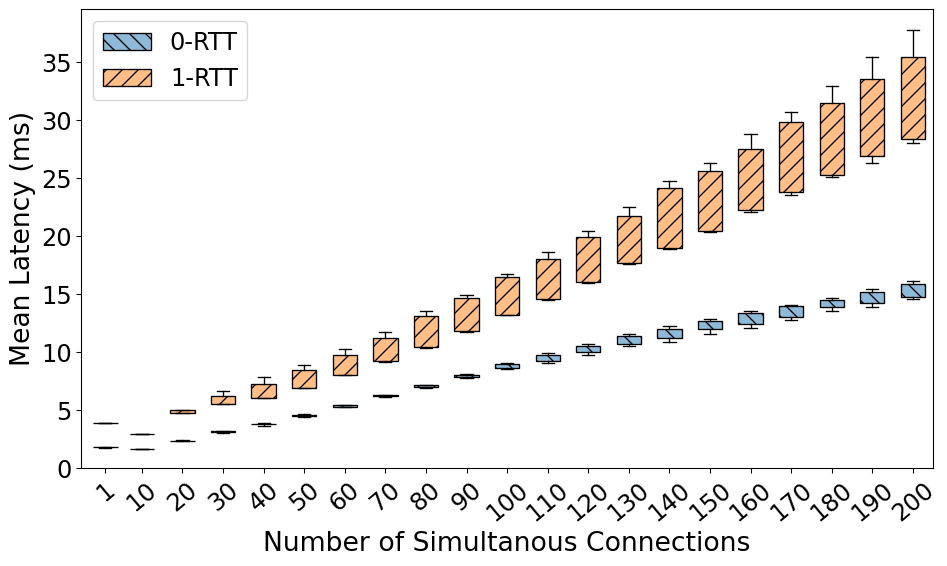

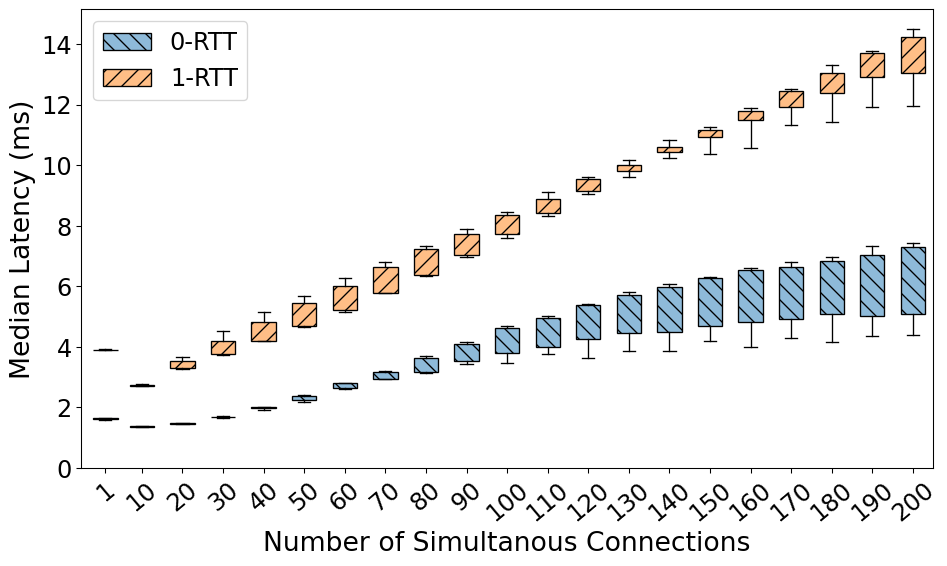

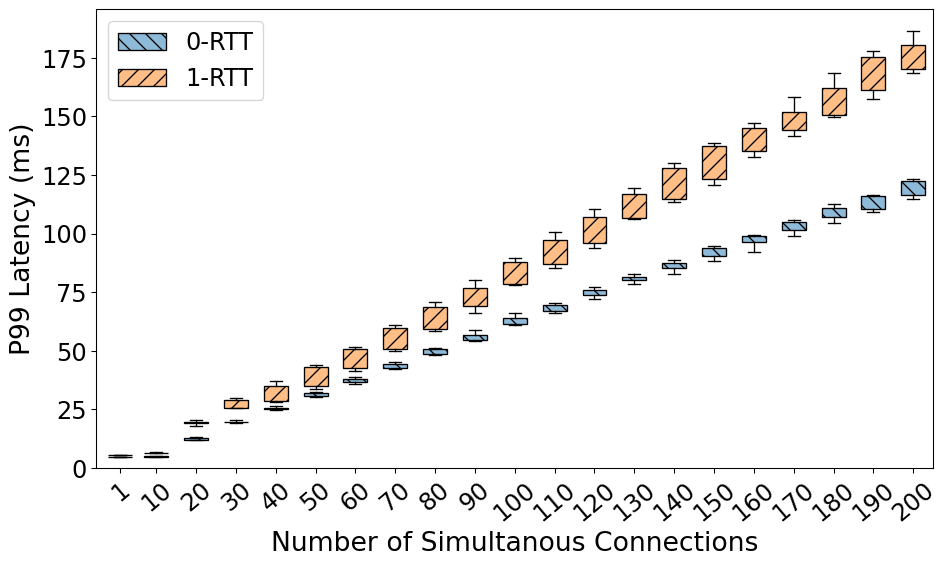

Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I24-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I25-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I26-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I27-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I28-P1-C0_rtt-server.data
Reading fi

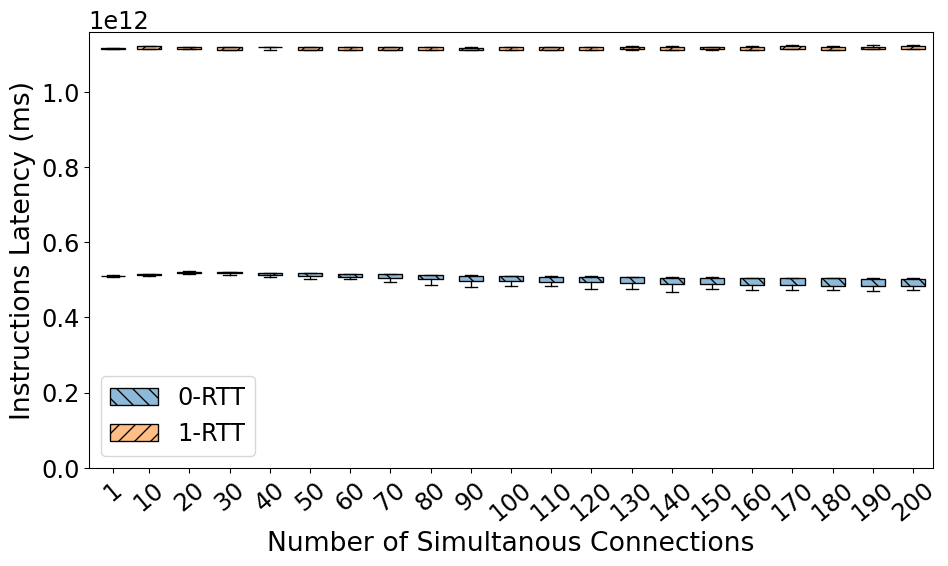

Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I24-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I25-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I26-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I27-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I28-P1-C0_rtt-server.data
Reading fi

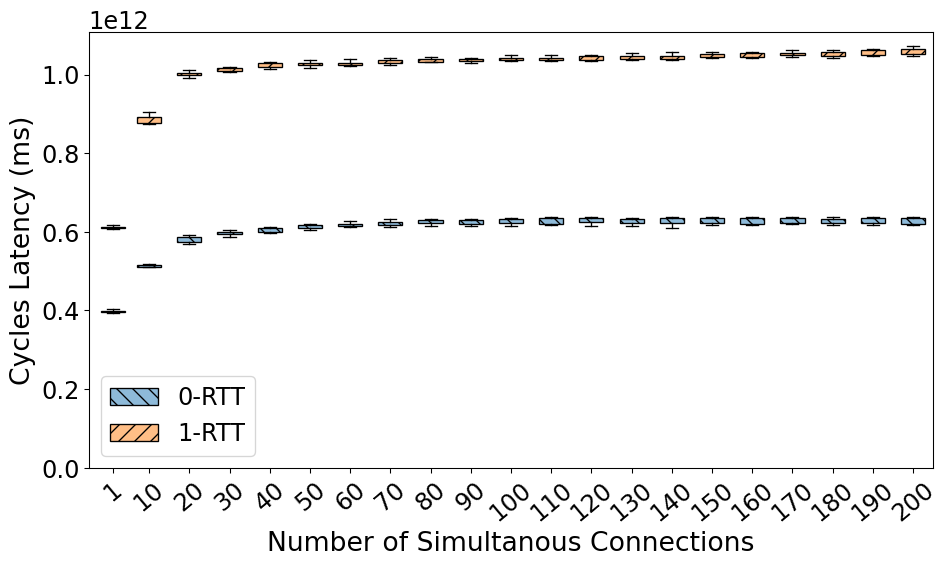

Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I24-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I25-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I26-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I27-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I28-P1-C0_rtt-server.data
Reading fi

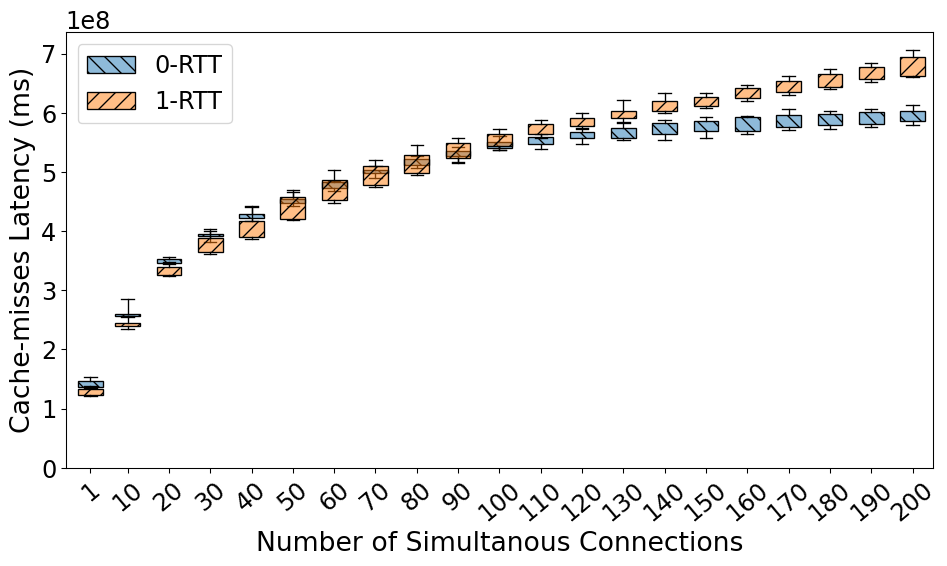

Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I24-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I25-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I26-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I27-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I28-P1-C0_rtt-server.data
Reading fi

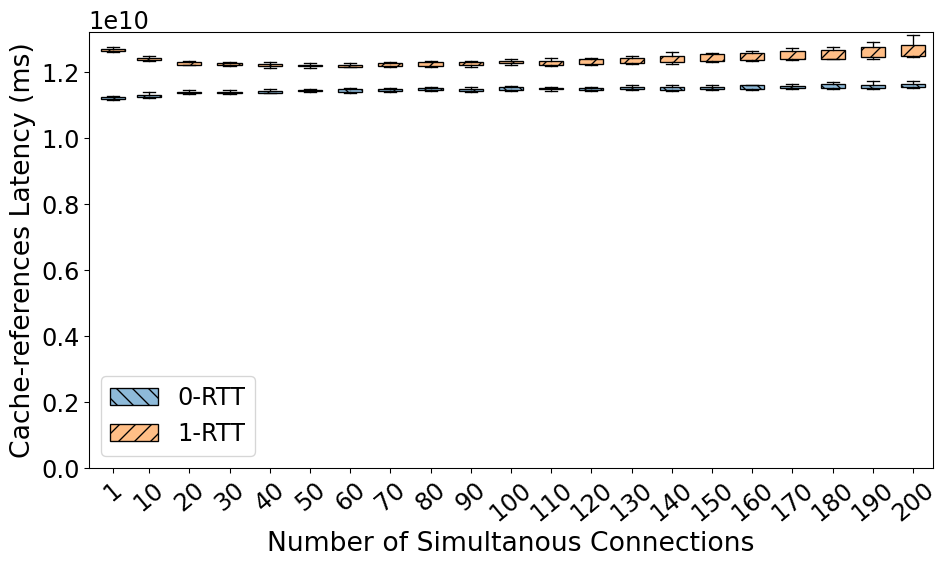

Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I24-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I25-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I26-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I27-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I28-P1-C0_rtt-server.data
Reading fi

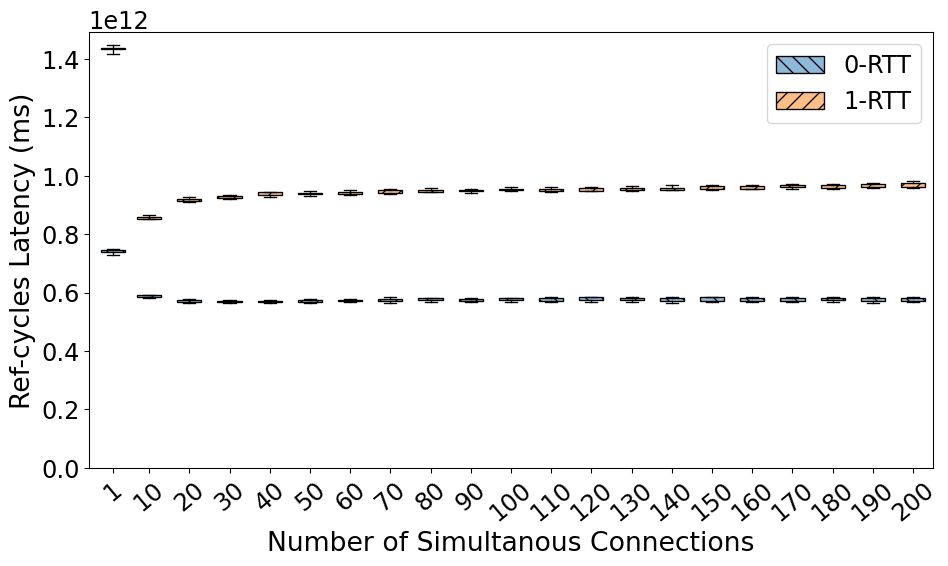

Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I24-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I25-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I26-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I27-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I28-P1-C0_rtt-server.data
Reading fi

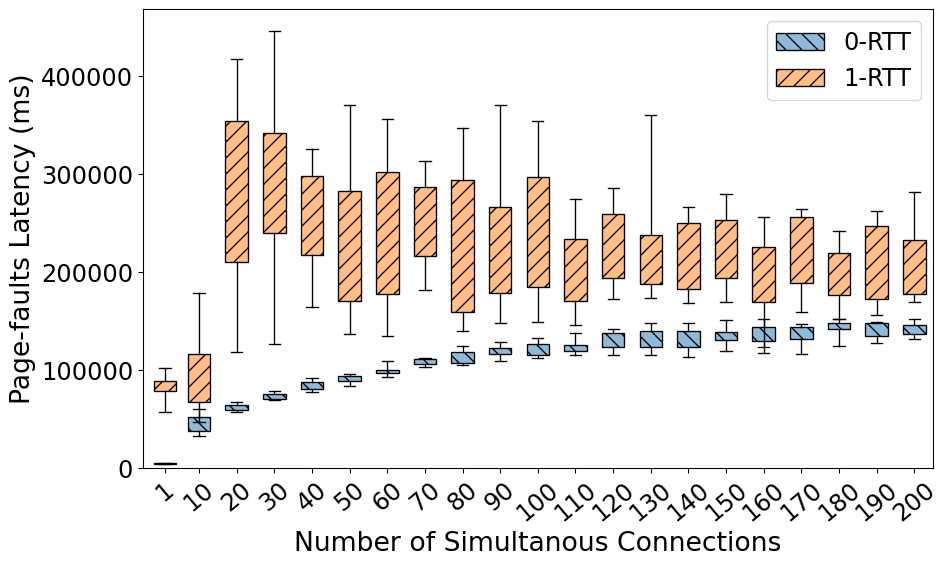

Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I24-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I25-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I26-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I27-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I28-P1-C0_rtt-server.data
Reading fi

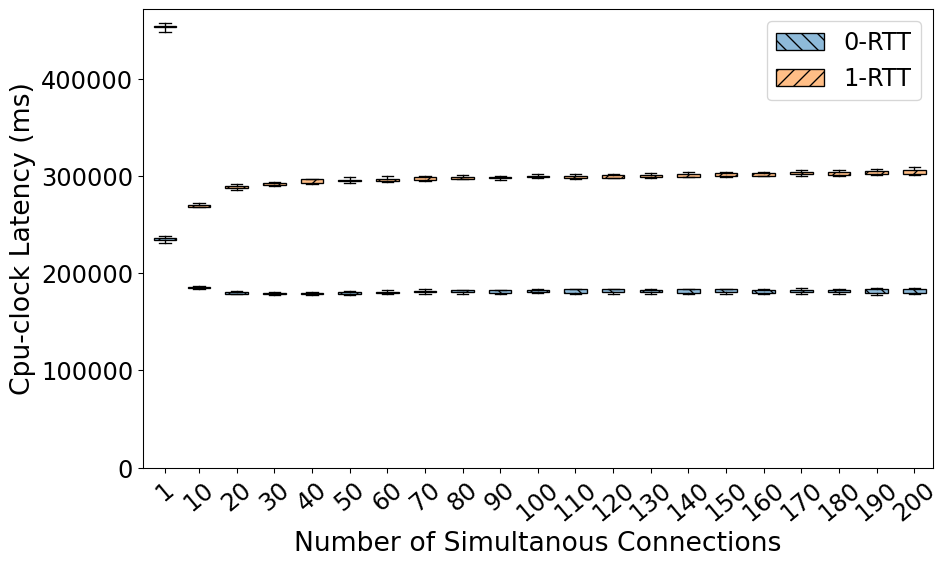

Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I24-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I25-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I26-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I27-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I28-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I29-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I30-P1-C0_rtt.da

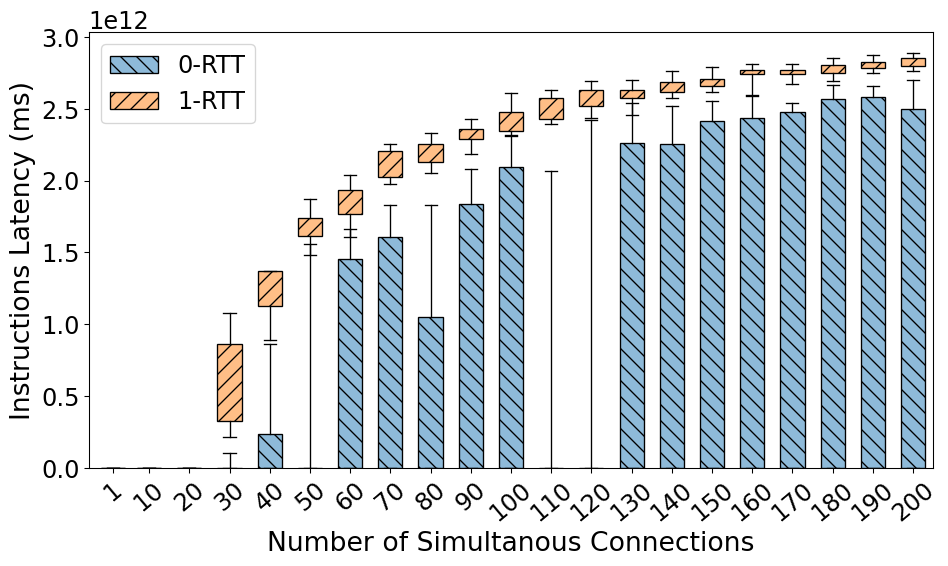

Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I24-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I25-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I26-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I27-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I28-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I29-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I30-P1-C0_rtt.da

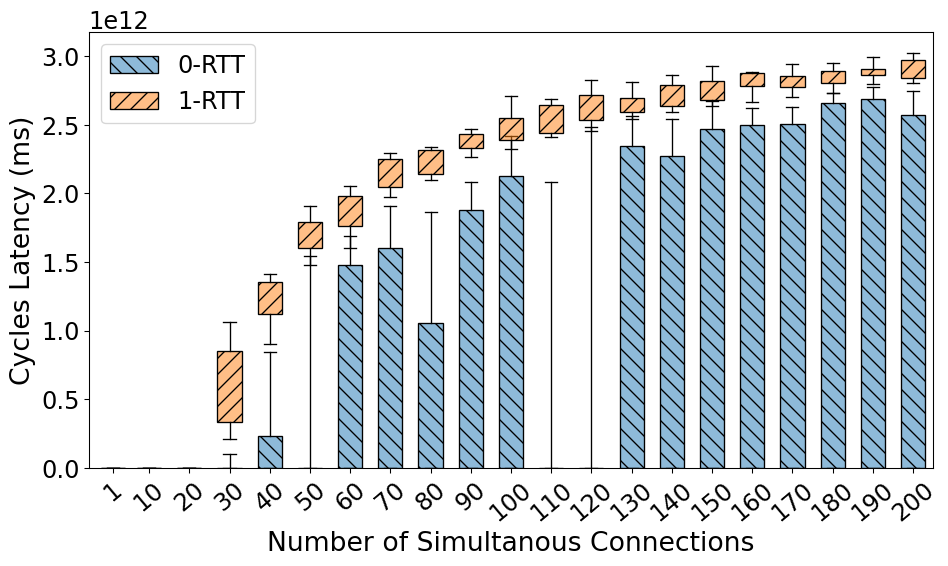

Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I24-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I25-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I26-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I27-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I28-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I29-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I30-P1-C0_rtt.da

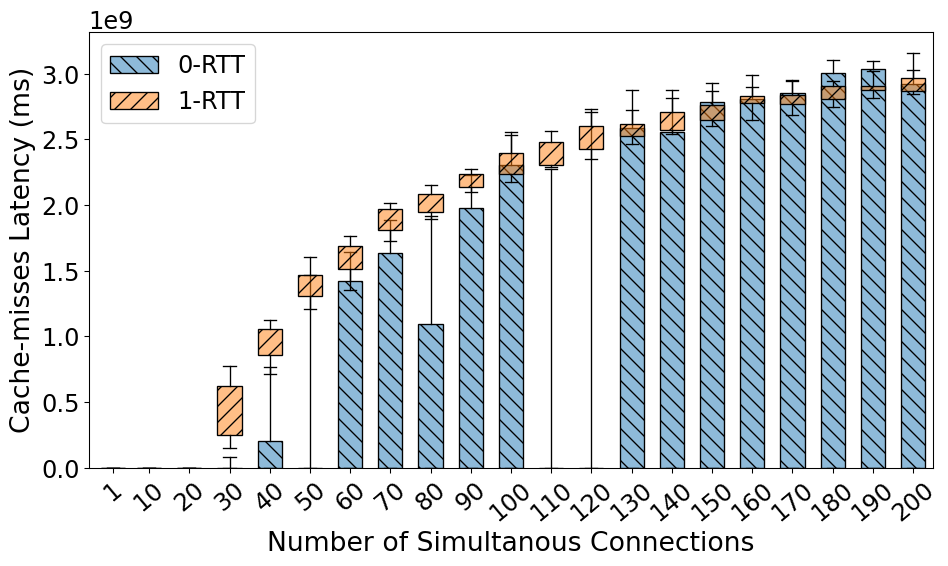

Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I24-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I25-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I26-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I27-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I28-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I29-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I30-P1-C0_rtt.da

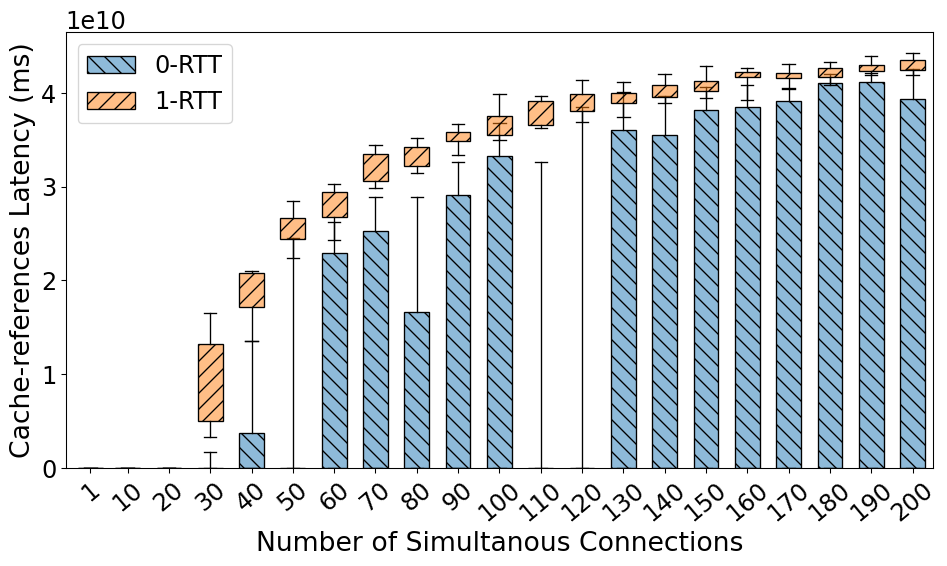

Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I24-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I25-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I26-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I27-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I28-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I29-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I30-P1-C0_rtt.da

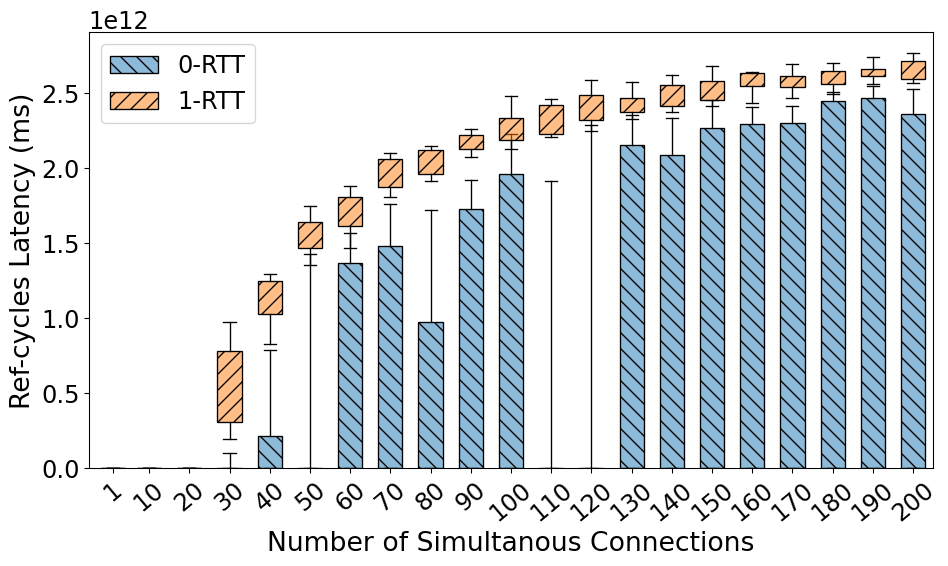

Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I24-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I25-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I26-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I27-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I28-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I29-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I30-P1-C0_rtt.da

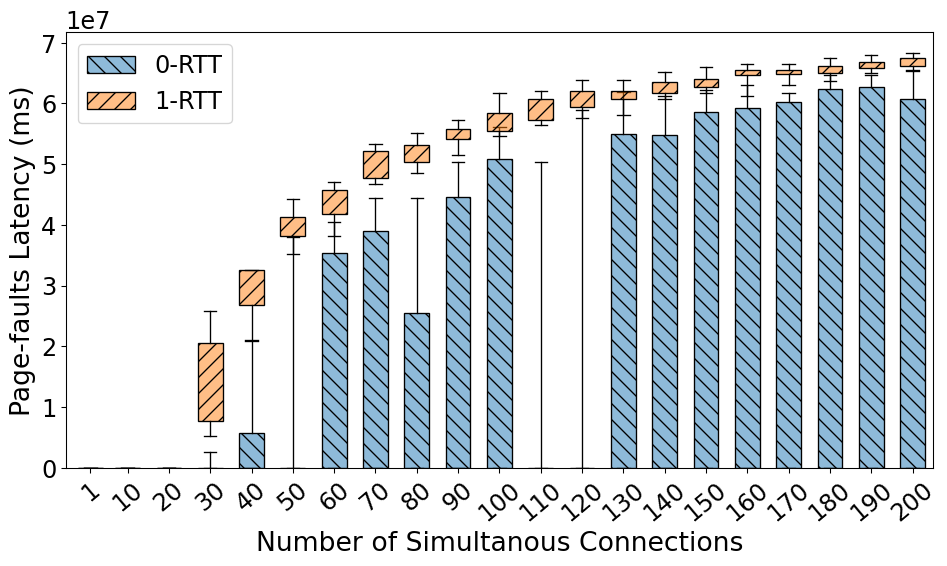

Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I24-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I25-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I26-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I27-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I28-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I29-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I30-P1-C0_rtt.da

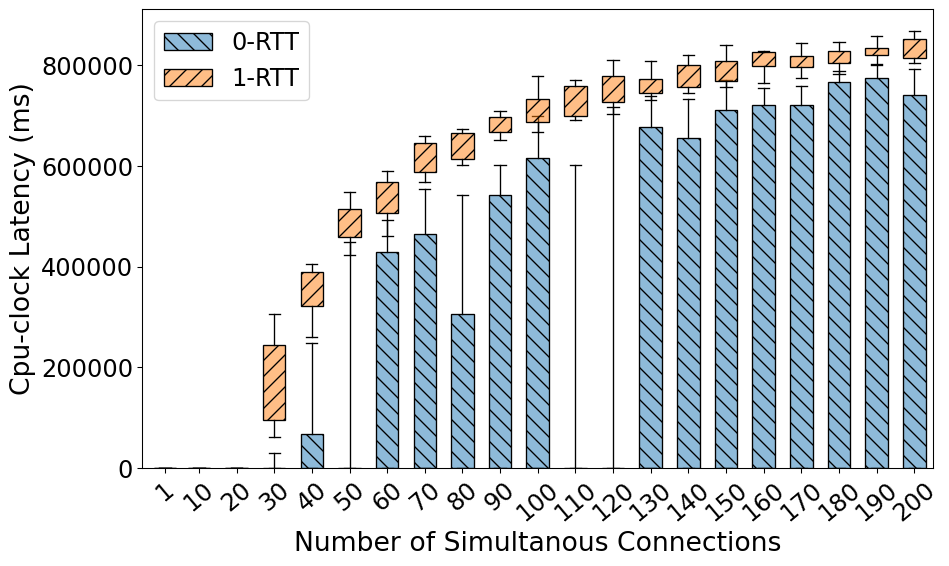

Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I24-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I25-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I26-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I27-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I28-P1-C0_rtt-server.data
Reading fi

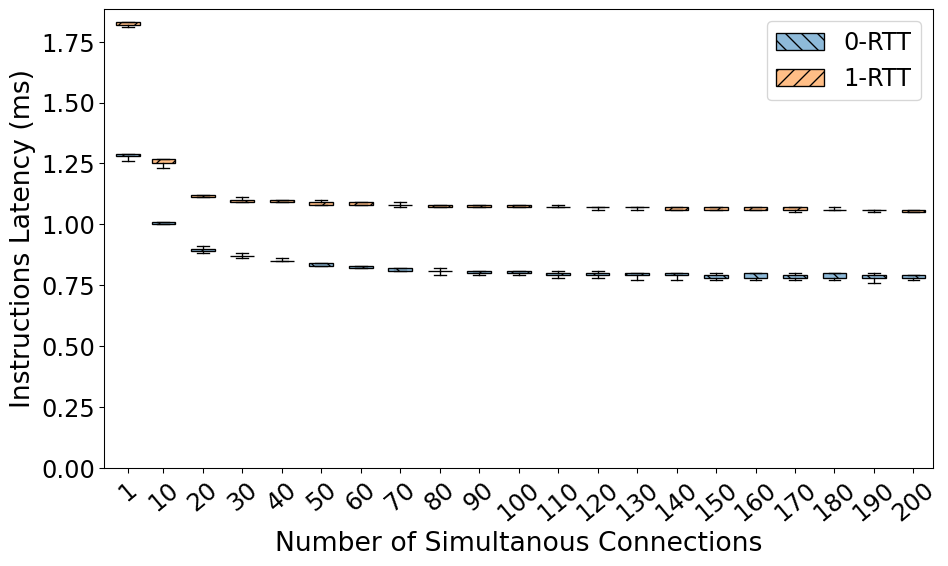

Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I24-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I25-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I26-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I27-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I28-P1-C0_rtt-server.data
Reading fi

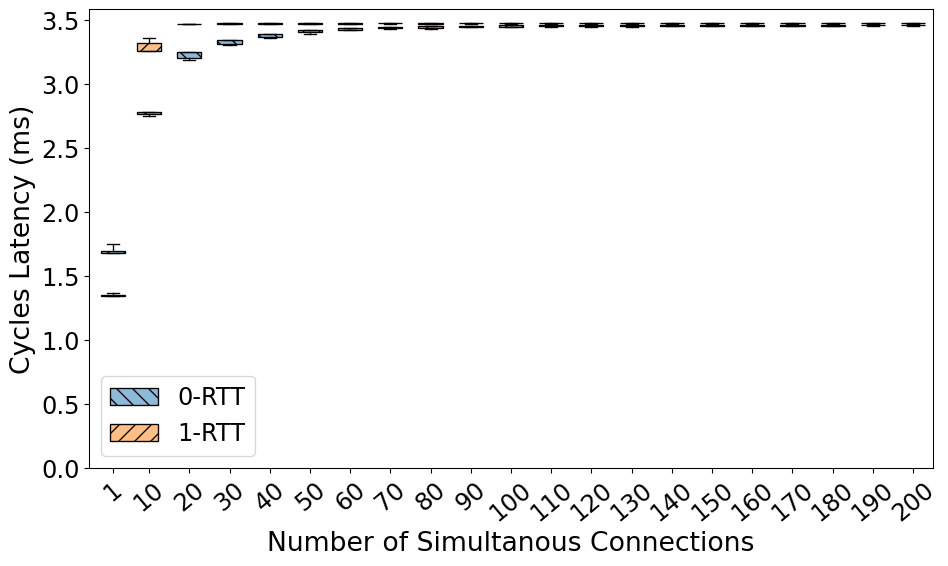

Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I24-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I25-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I26-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I27-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I28-P1-C0_rtt-server.data
Reading fi

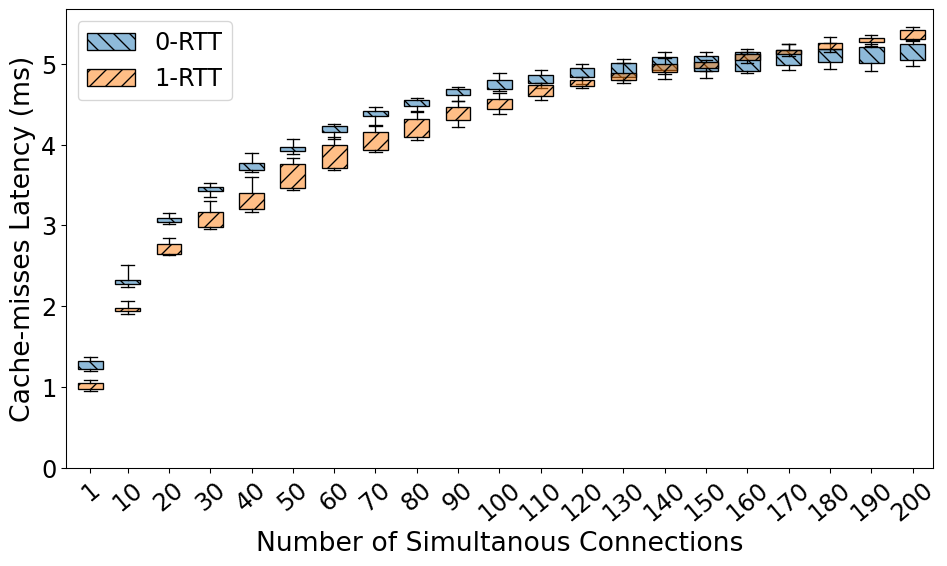

Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I24-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I25-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I26-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I27-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I28-P1-C0_rtt-server.data
Reading fi

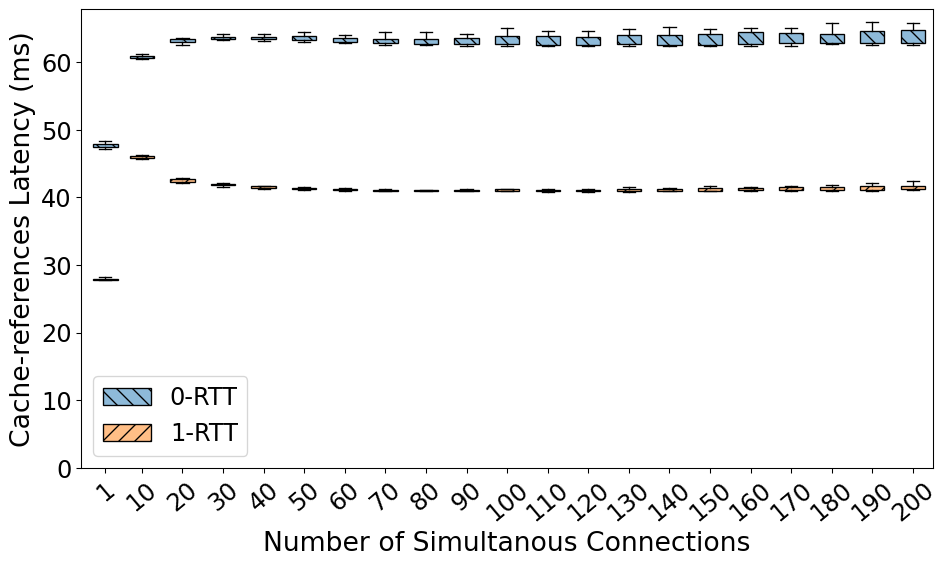

Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I24-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I25-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I26-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I27-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I28-P1-C0_rtt-server.data
Reading fi

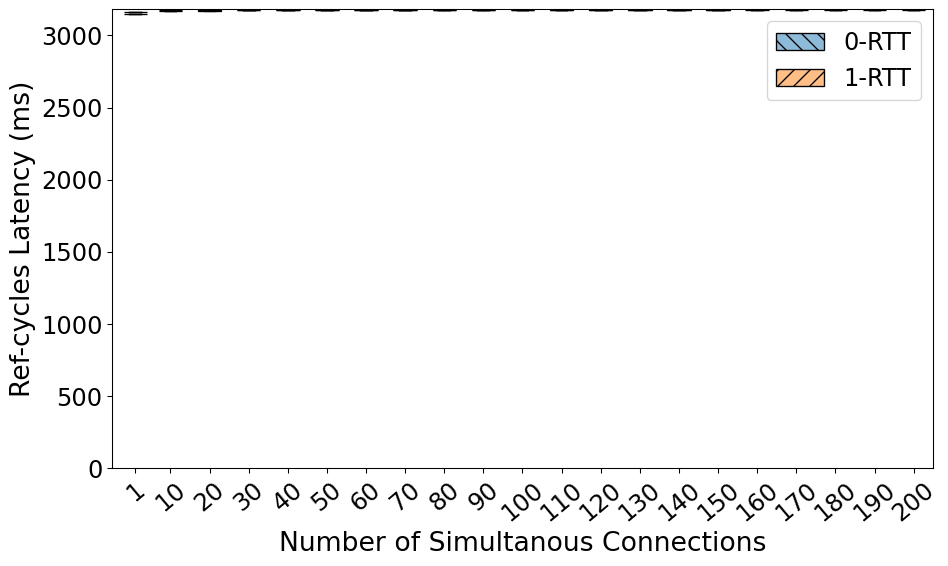

Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I24-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I25-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I26-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I27-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I28-P1-C0_rtt-server.data
Reading fi

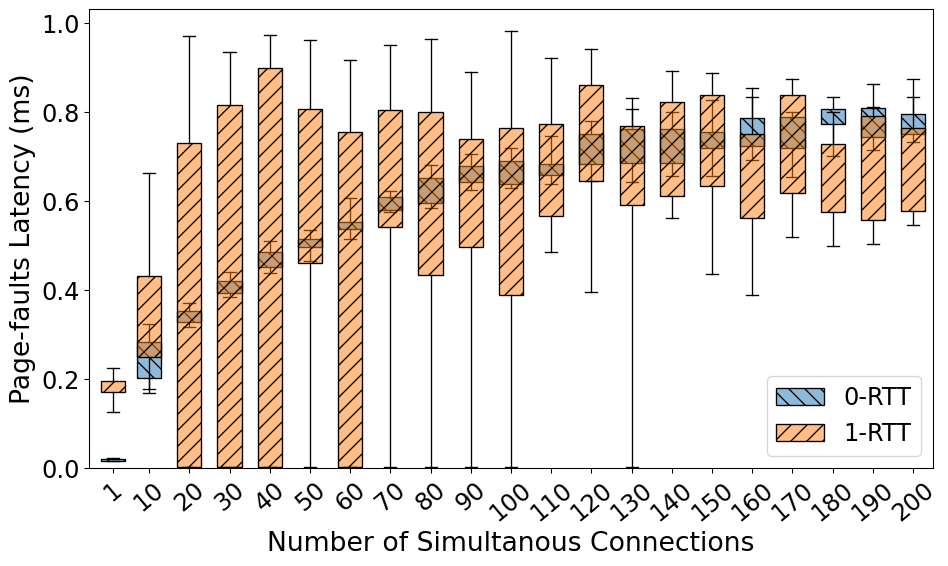

Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I24-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I25-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I26-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I27-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I28-P1-C0_rtt-server.data
Reading fi

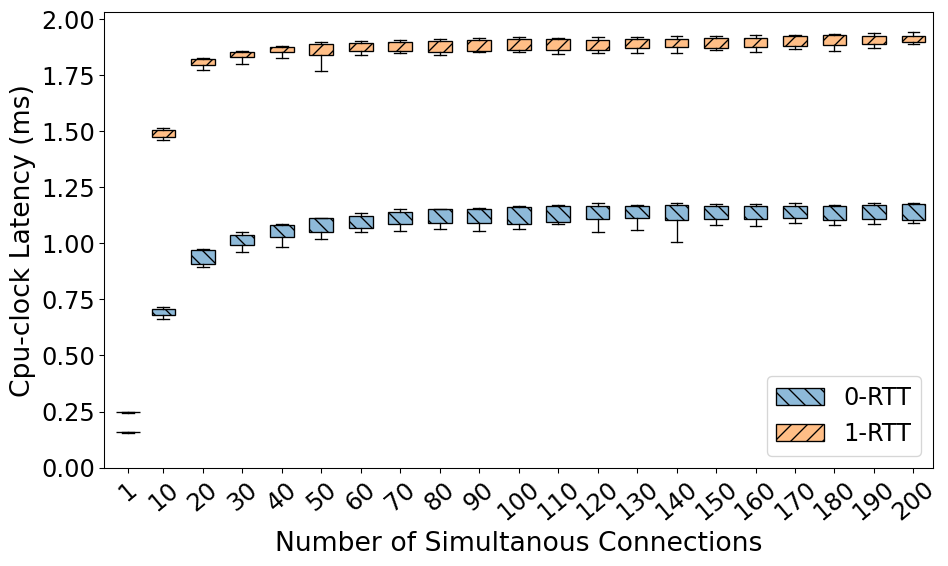

Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I24-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I25-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I26-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I27-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I28-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I29-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I30-P1-C0_rtt.da

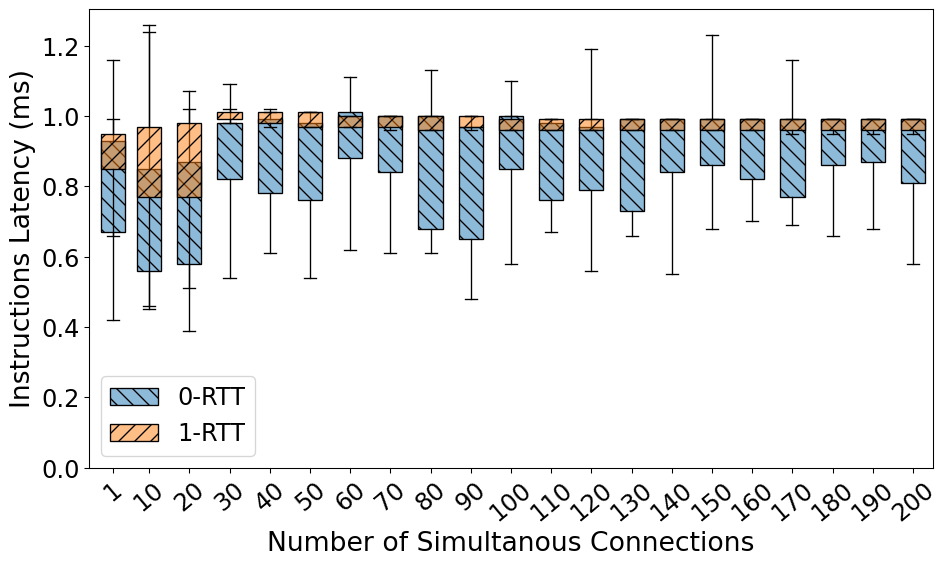

Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I24-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I25-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I26-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I27-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I28-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I29-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I30-P1-C0_rtt.da

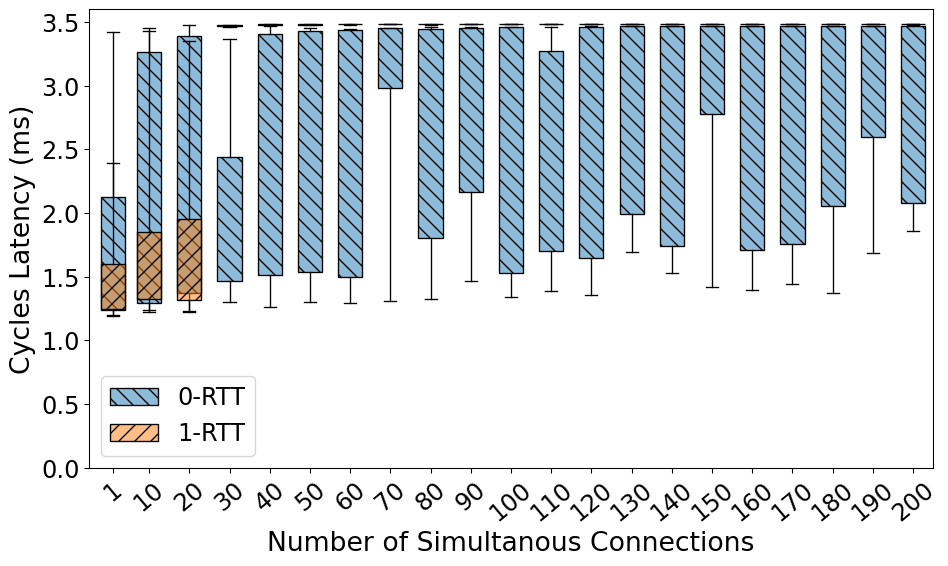

Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I24-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I25-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I26-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I27-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I28-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I29-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I30-P1-C0_rtt.da

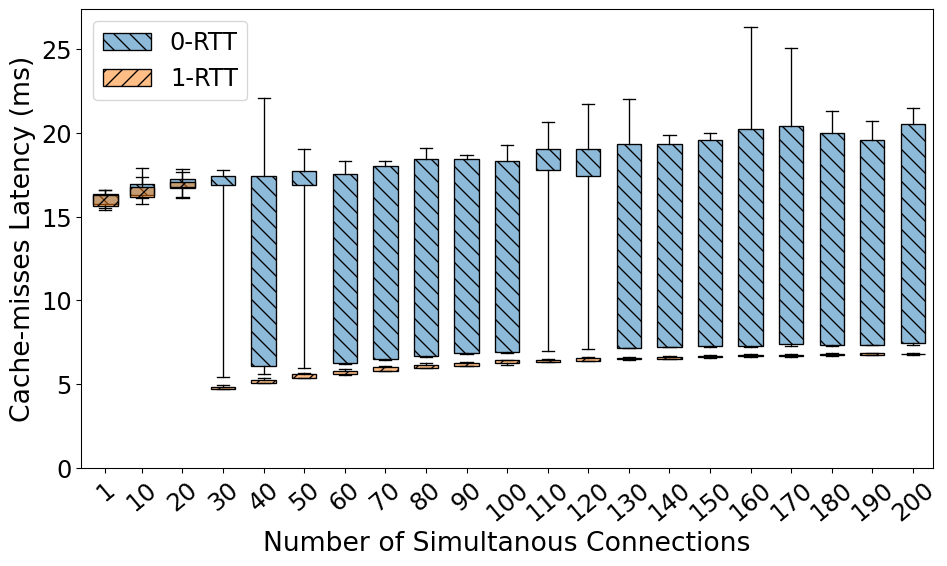

Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I24-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I25-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I26-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I27-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I28-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I29-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I30-P1-C0_rtt.da

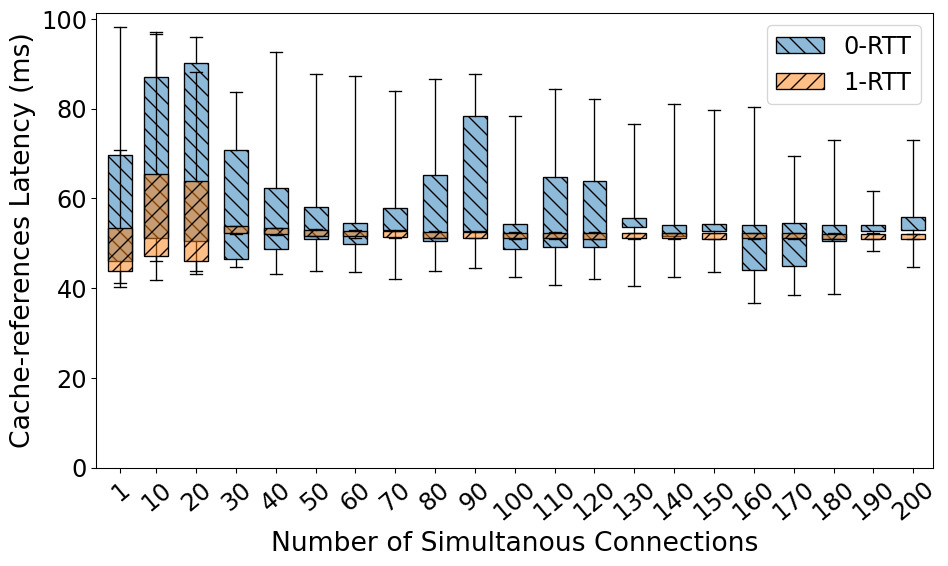

Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I24-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I25-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I26-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I27-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I28-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I29-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I30-P1-C0_rtt.da

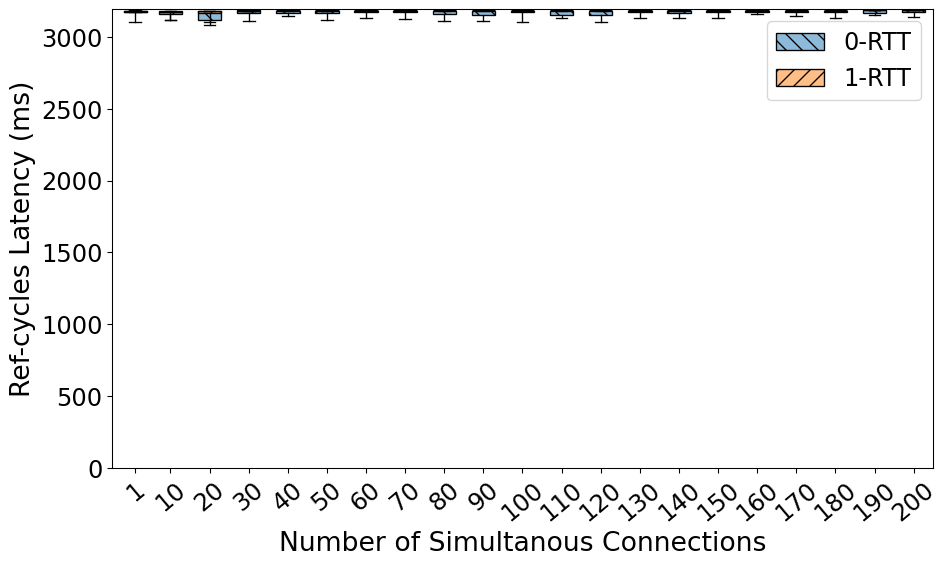

Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I24-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I25-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I26-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I27-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I28-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I29-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I30-P1-C0_rtt.da

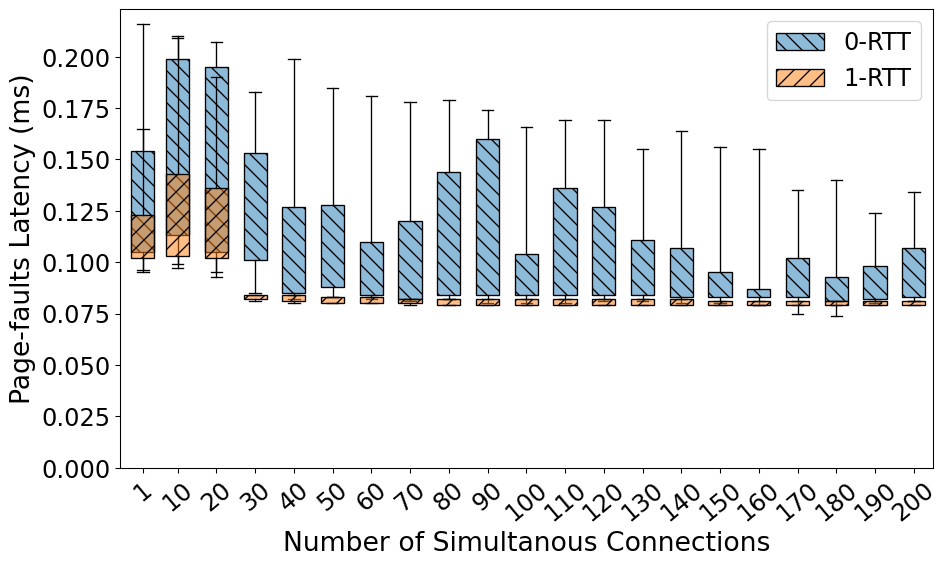

Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I24-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I25-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I26-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I27-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I28-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I29-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I30-P1-C0_rtt.da

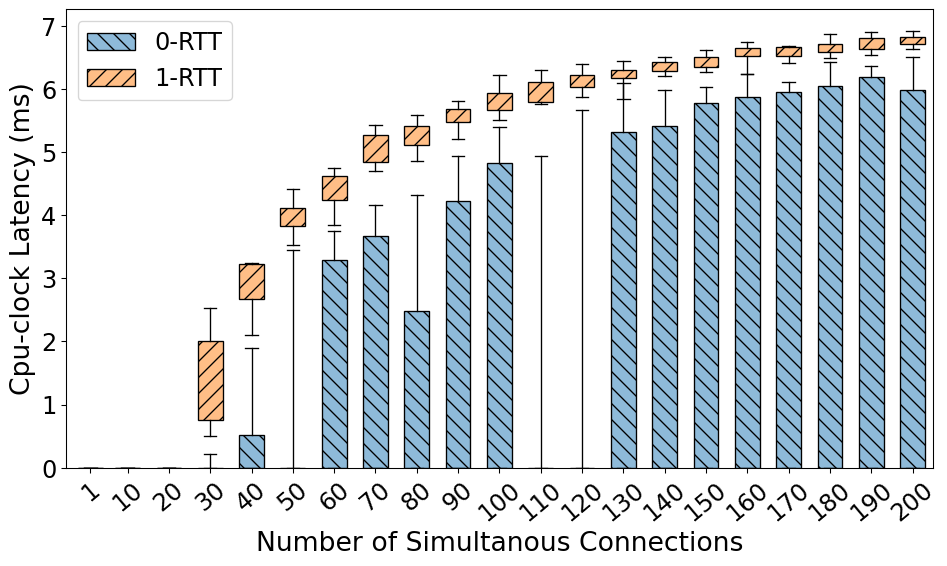

In [16]:
plot_combined(start_iteration=14, num_of_iterations=21)

Reading file: v2-parallel-I1-P1-C.csv
Reading file: v2-parallel-I2-P1-C.csv
Reading file: v2-parallel-I3-P1-C.csv
Reading file: v2-parallel-I4-P1-C.csv
Reading file: v2-parallel-I5-P1-C.csv
Reading file: v2-parallel-I6-P1-C.csv
Reading file: v2-parallel-I7-P1-C.csv
Reading file: v2-parallel-I8-P1-C.csv
Reading file: v2-parallel-I9-P1-C.csv
Reading file: v2-parallel-I10-P1-C.csv
Reading file: v2-parallel-I11-P1-C.csv
Reading file: v2-parallel-I1-P5-C.csv
Reading file: v2-parallel-I2-P5-C.csv
Reading file: v2-parallel-I3-P5-C.csv
Reading file: v2-parallel-I4-P5-C.csv
Reading file: v2-parallel-I5-P5-C.csv
Reading file: v2-parallel-I6-P5-C.csv
Reading file: v2-parallel-I7-P5-C.csv
Reading file: v2-parallel-I8-P5-C.csv
Reading file: v2-parallel-I9-P5-C.csv
Reading file: v2-parallel-I10-P5-C.csv
Reading file: v2-parallel-I11-P5-C.csv
Reading file: v2-parallel-I1-P10-C.csv
Reading file: v2-parallel-I2-P10-C.csv
Reading file: v2-parallel-I3-P10-C.csv
Reading file: v2-parallel-I4-P10-C.csv
Read

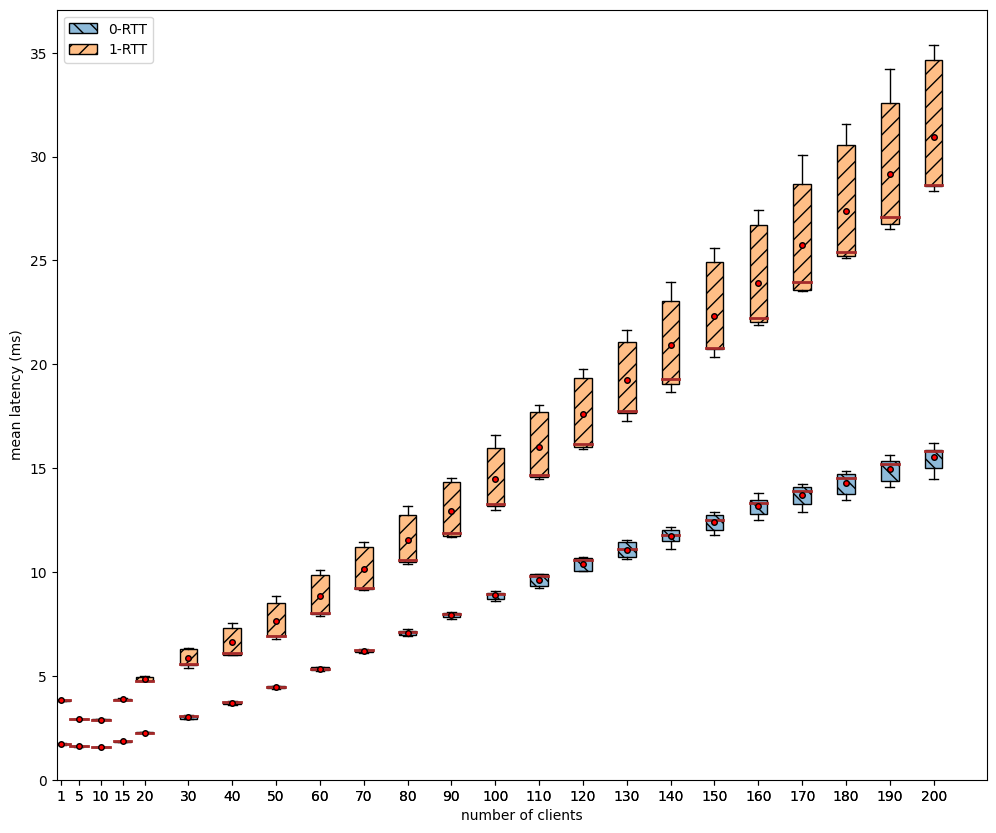

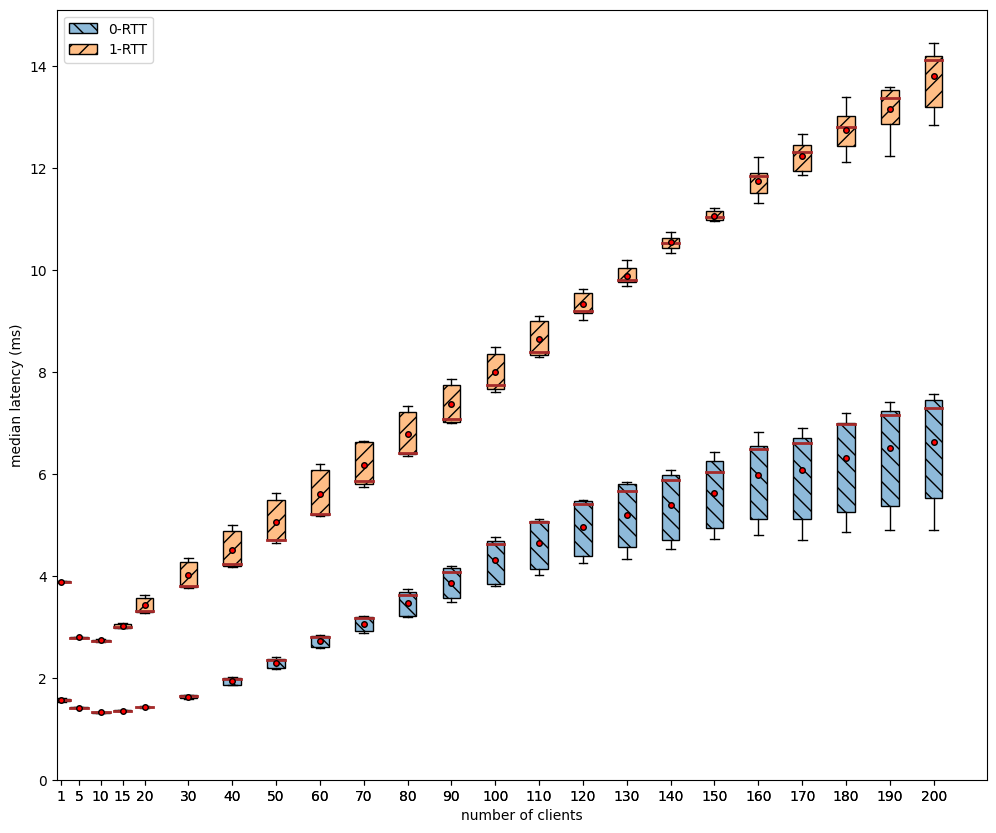

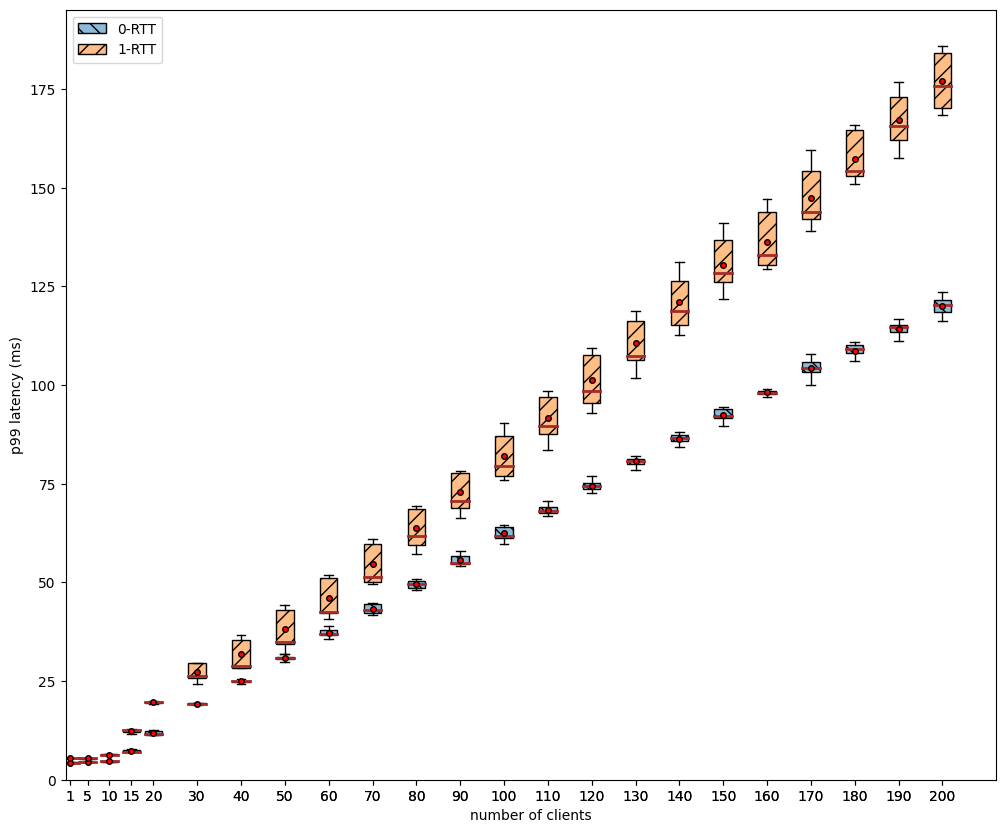

Reading file perf-data/perf-v2-parallel-I13-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I13-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I14-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P5-C0_rtt-server.data
Reading fi

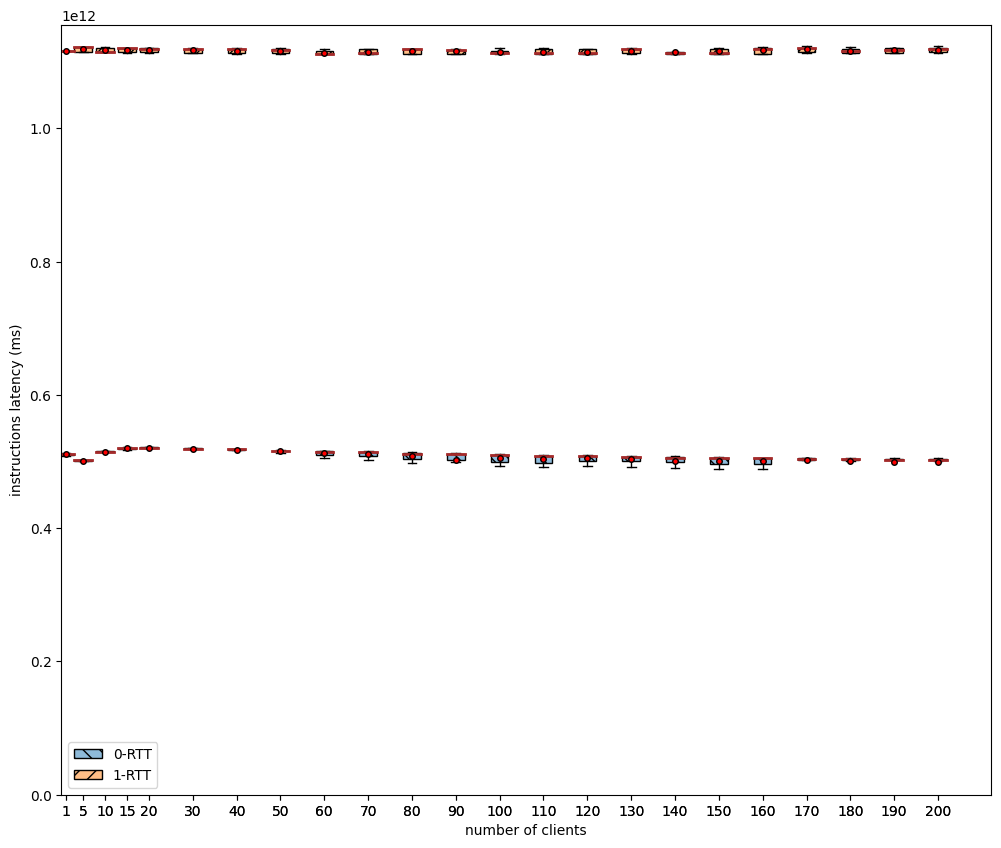

Reading file perf-data/perf-v2-parallel-I13-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I13-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I14-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P5-C0_rtt-server.data
Reading fi

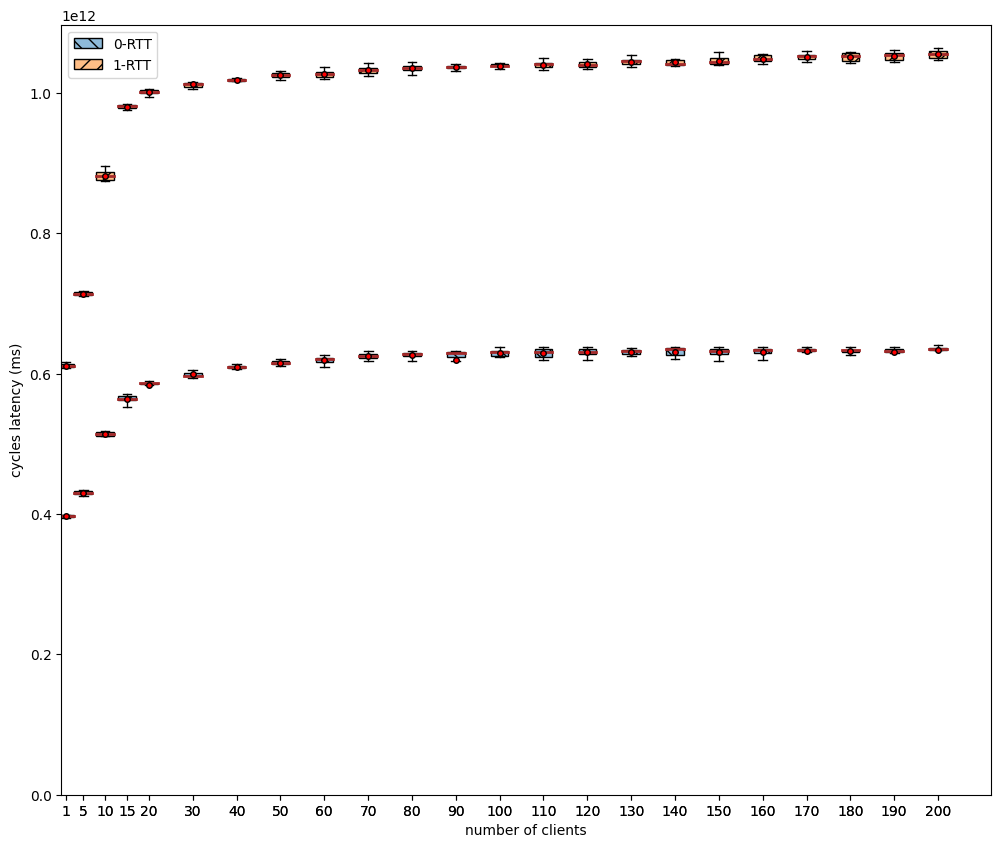

Reading file perf-data/perf-v2-parallel-I13-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I13-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I14-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P5-C0_rtt-server.data
Reading fi

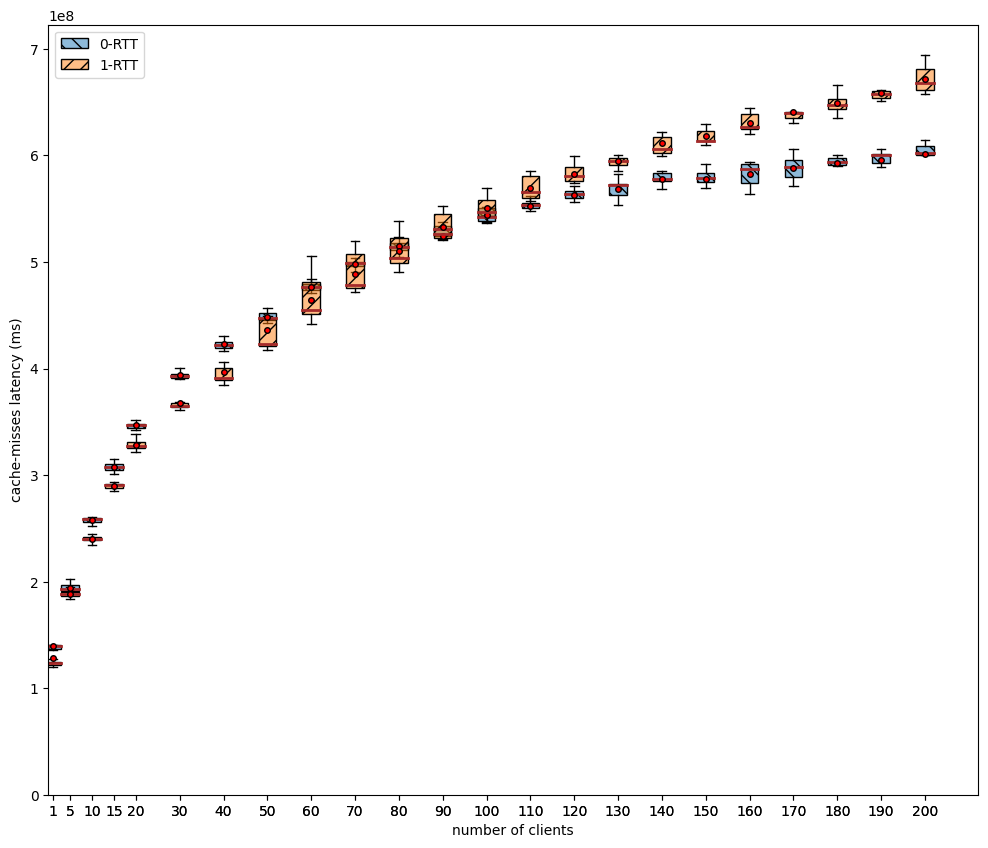

Reading file perf-data/perf-v2-parallel-I13-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I13-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I14-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P5-C0_rtt-server.data
Reading fi

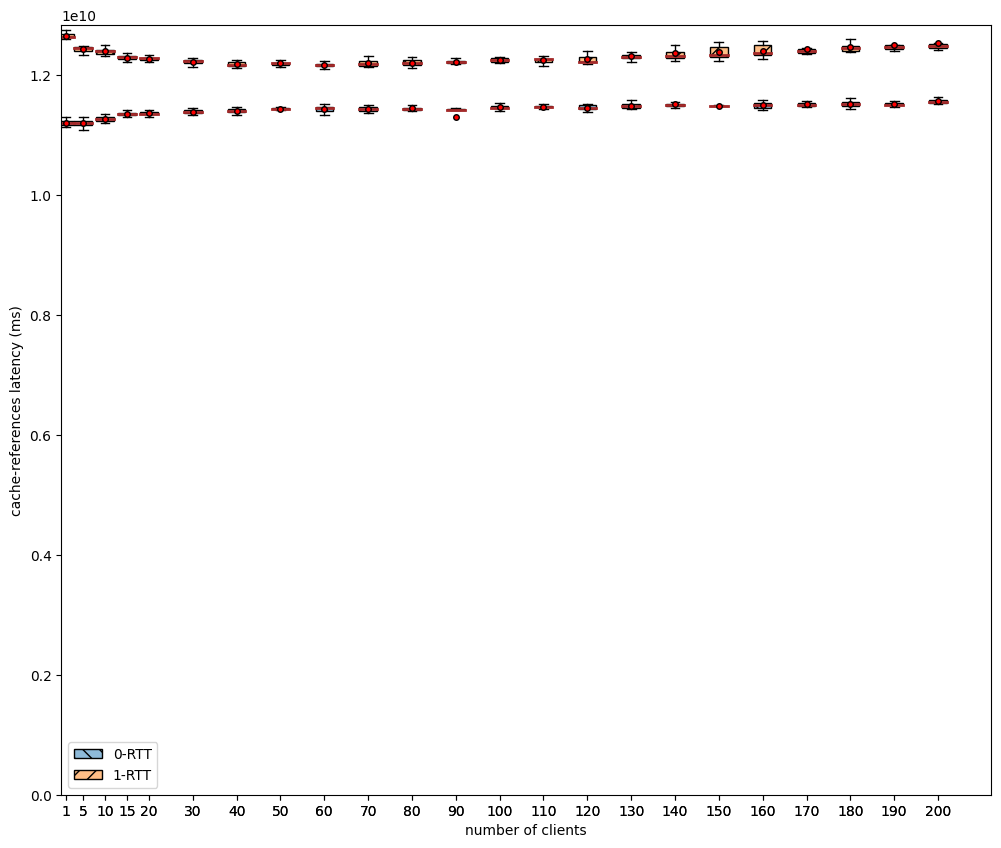

Reading file perf-data/perf-v2-parallel-I13-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I13-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I14-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P5-C0_rtt-server.data
Reading fi

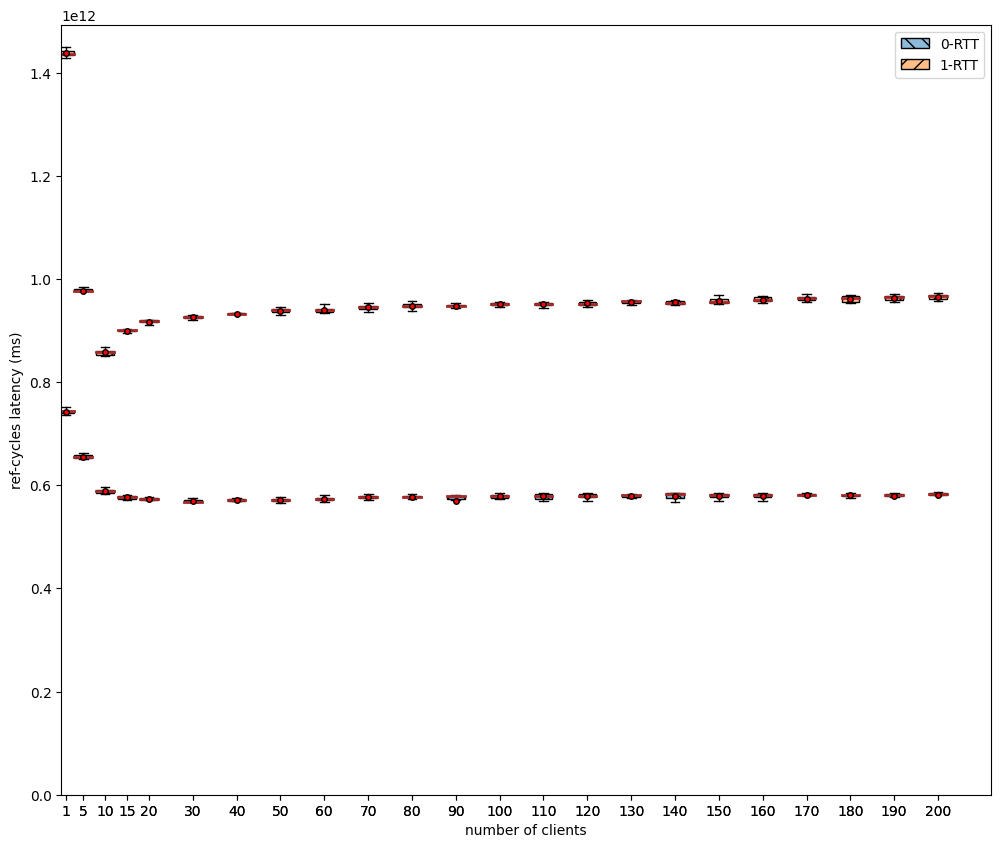

Reading file perf-data/perf-v2-parallel-I13-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I13-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I14-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P5-C0_rtt-server.data
Reading fi

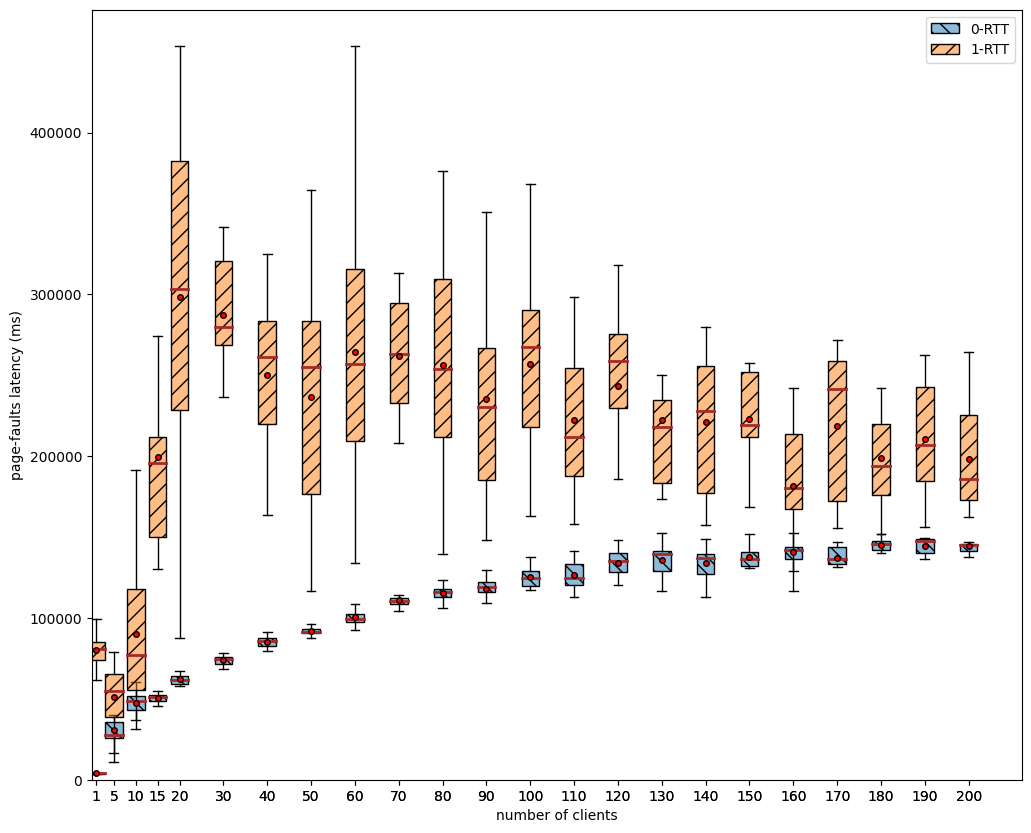

Reading file perf-data/perf-v2-parallel-I13-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I13-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I14-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P5-C0_rtt-server.data
Reading fi

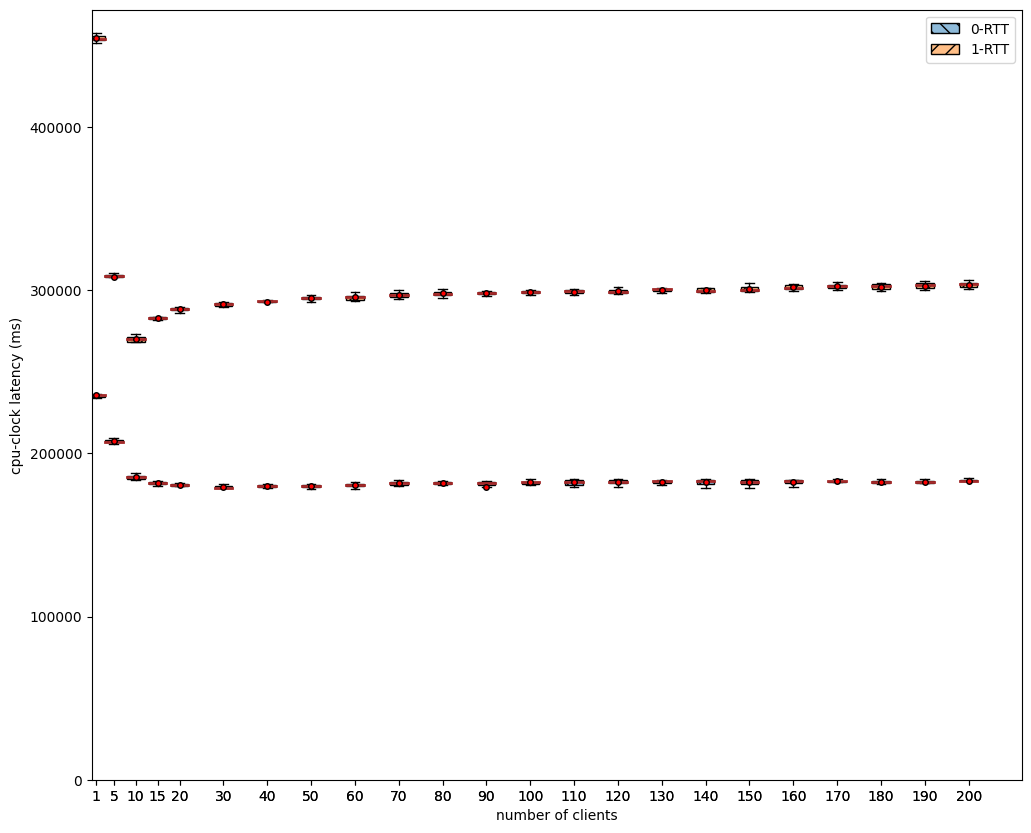

Reading file perf-data/perf-v2-parallel-I13-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I13-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I14-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P5-C0_rtt.da

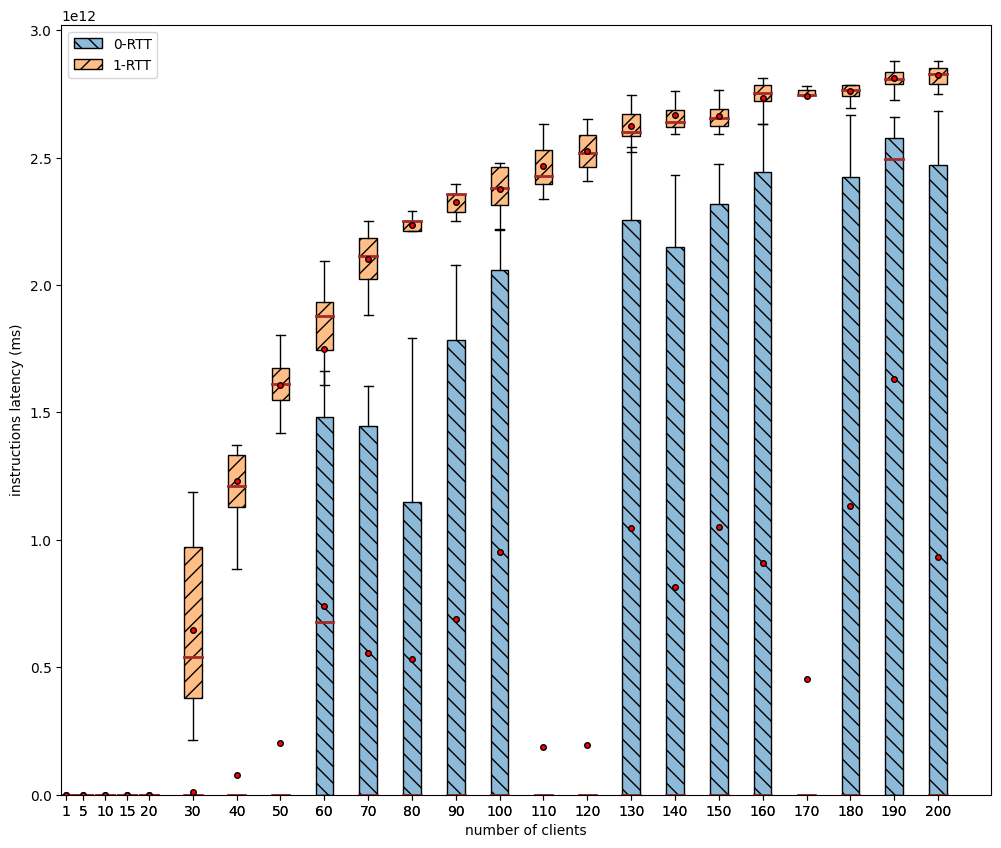

Reading file perf-data/perf-v2-parallel-I13-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I13-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I14-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P5-C0_rtt.da

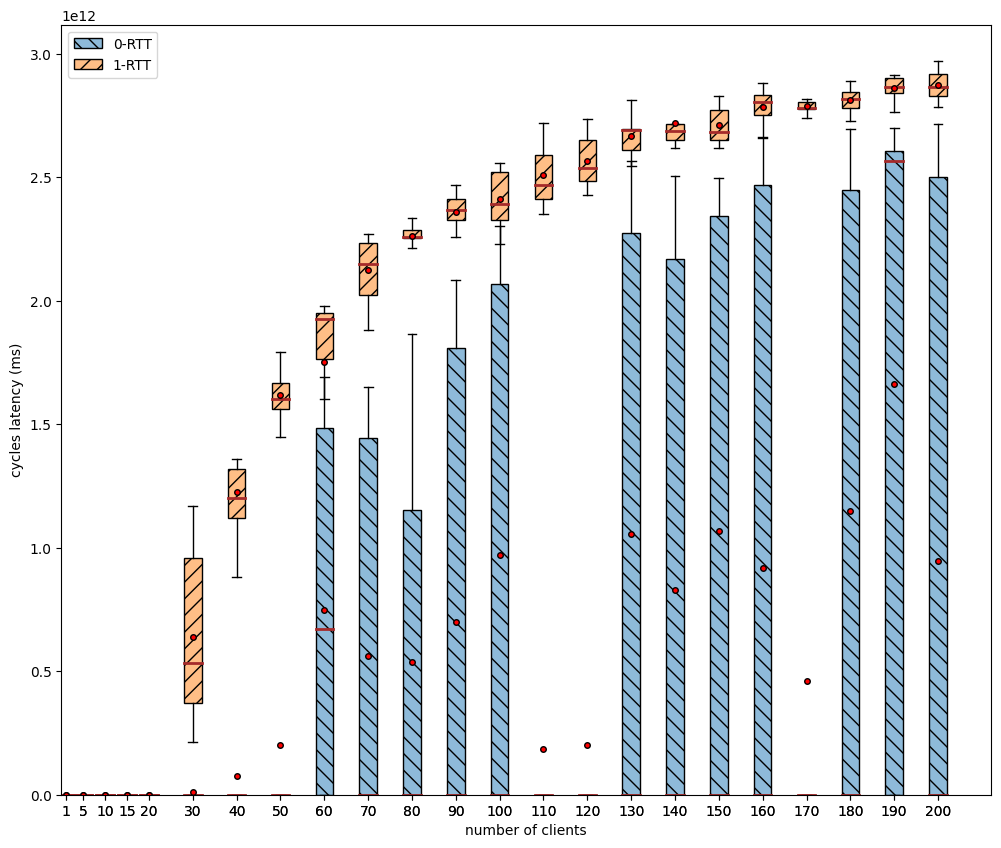

Reading file perf-data/perf-v2-parallel-I13-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I13-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I14-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P5-C0_rtt.da

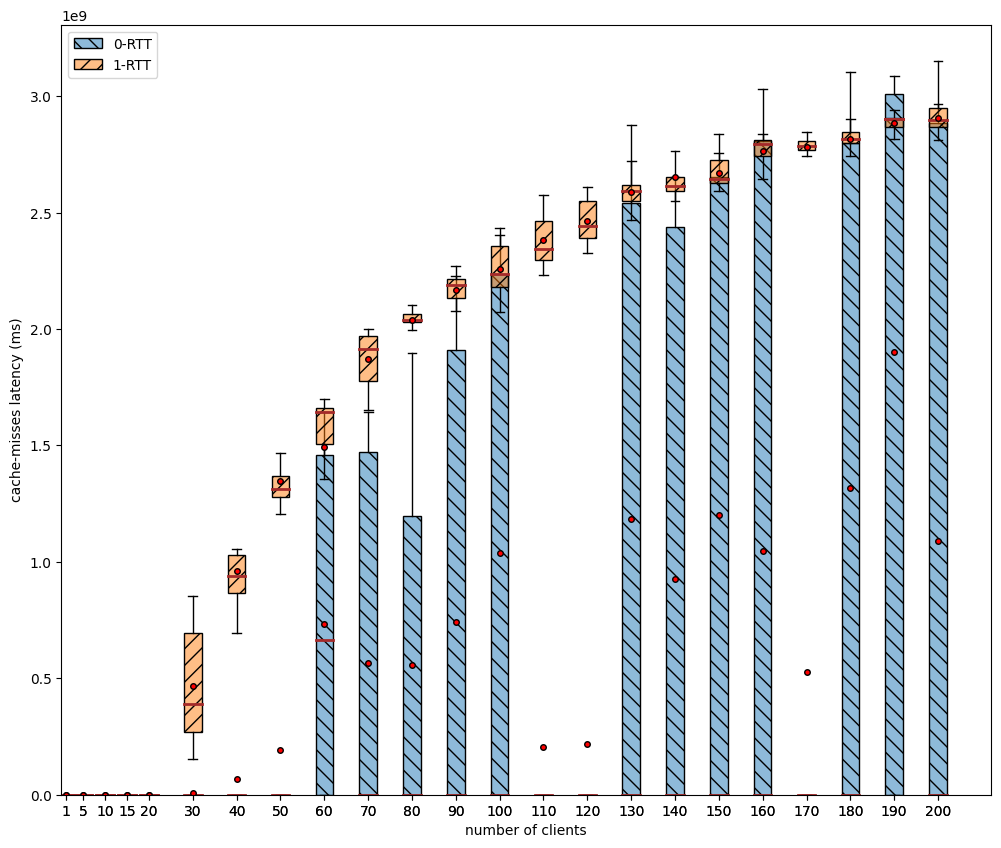

Reading file perf-data/perf-v2-parallel-I13-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I13-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I14-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P5-C0_rtt.da

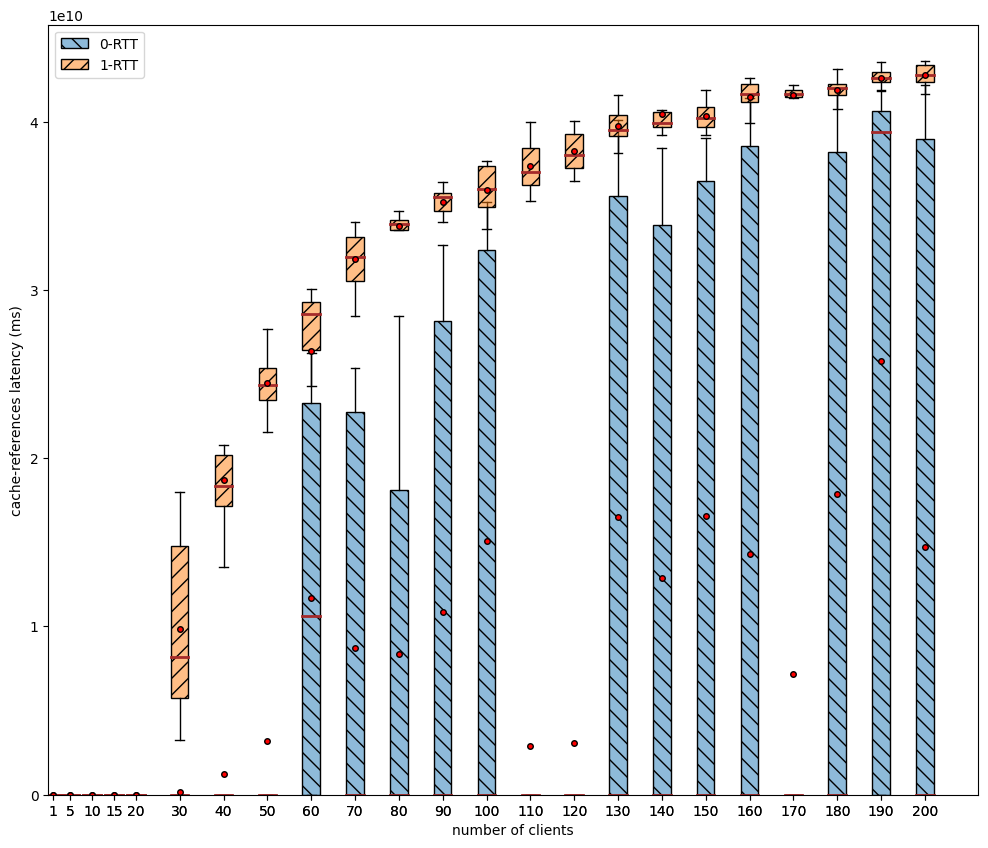

Reading file perf-data/perf-v2-parallel-I13-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I13-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I14-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P5-C0_rtt.da

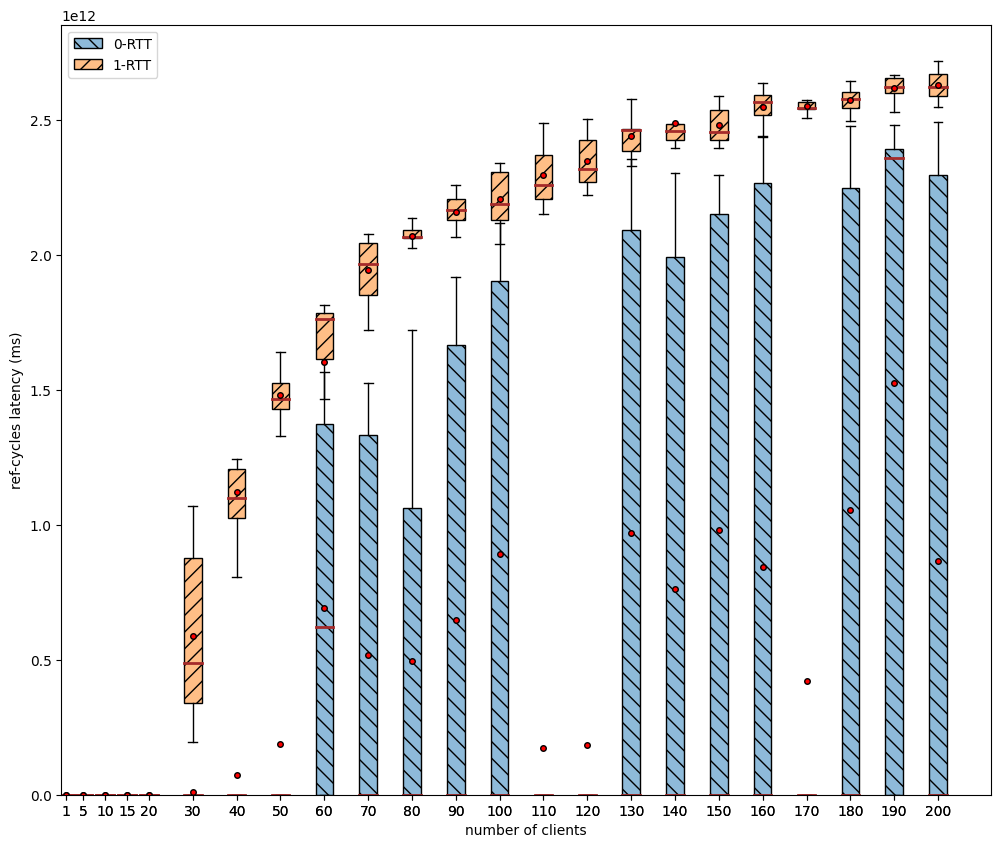

Reading file perf-data/perf-v2-parallel-I13-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I13-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I14-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P5-C0_rtt.da

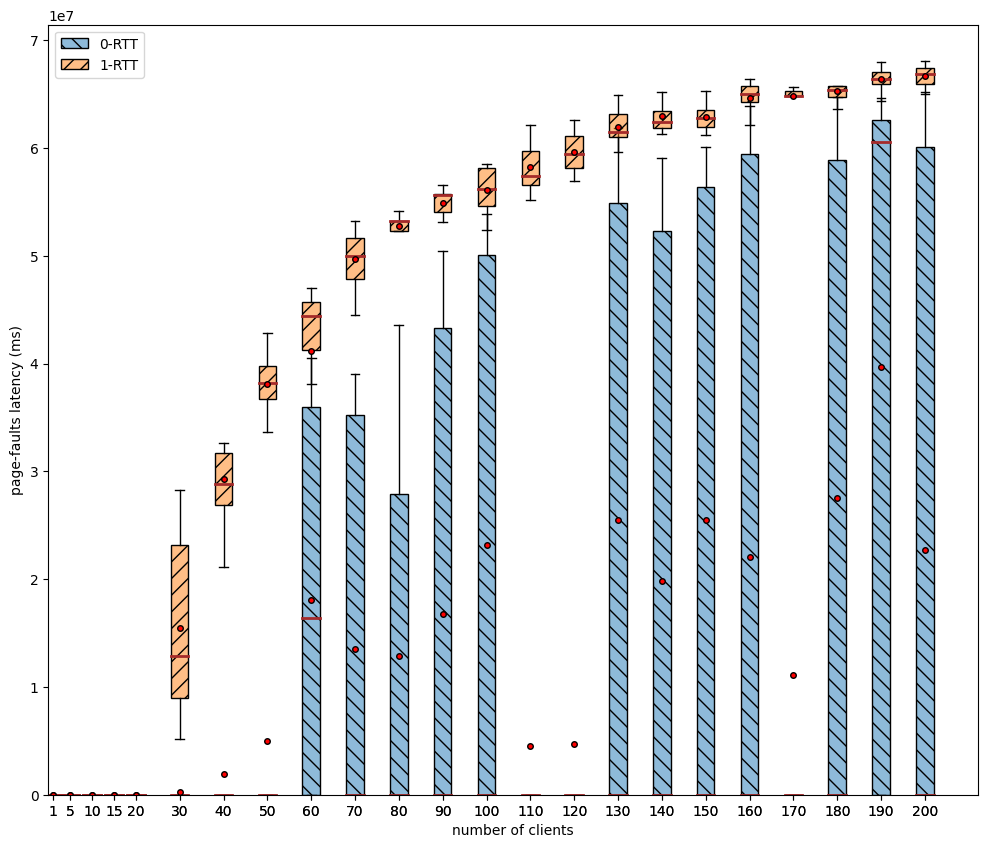

Reading file perf-data/perf-v2-parallel-I13-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I13-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I14-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P5-C0_rtt.da

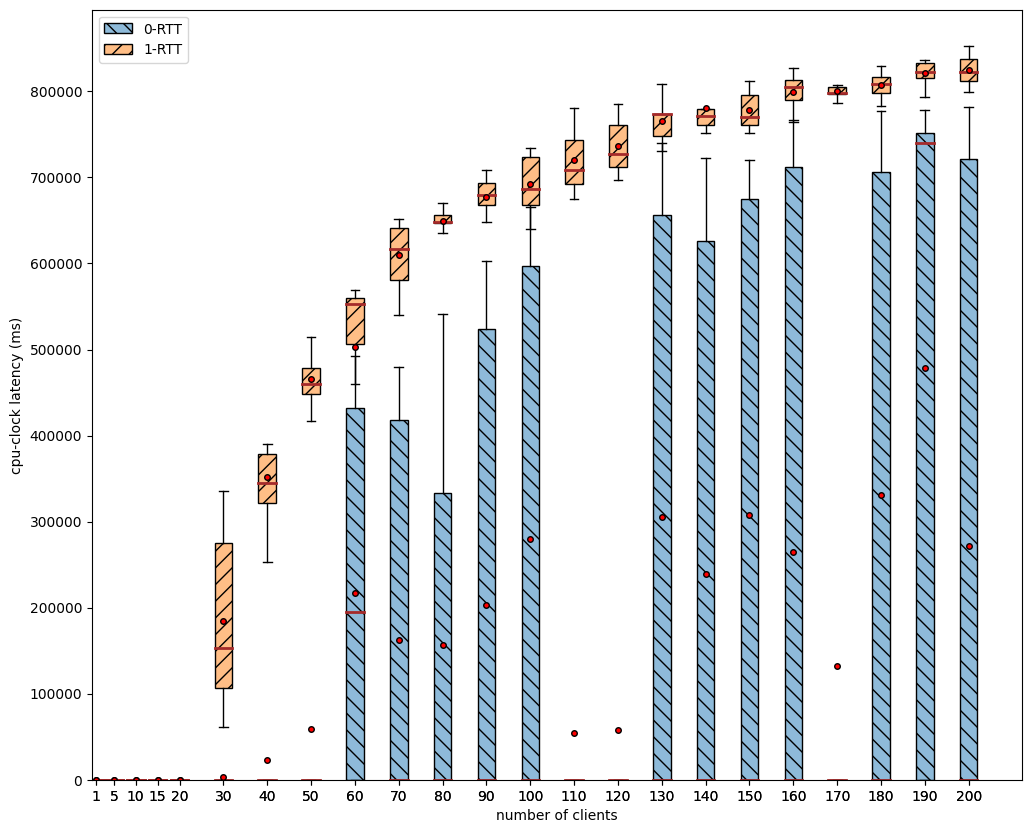

Reading file perf-data/perf-v2-parallel-I13-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I13-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I14-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P5-C0_rtt-server.data
Reading fi

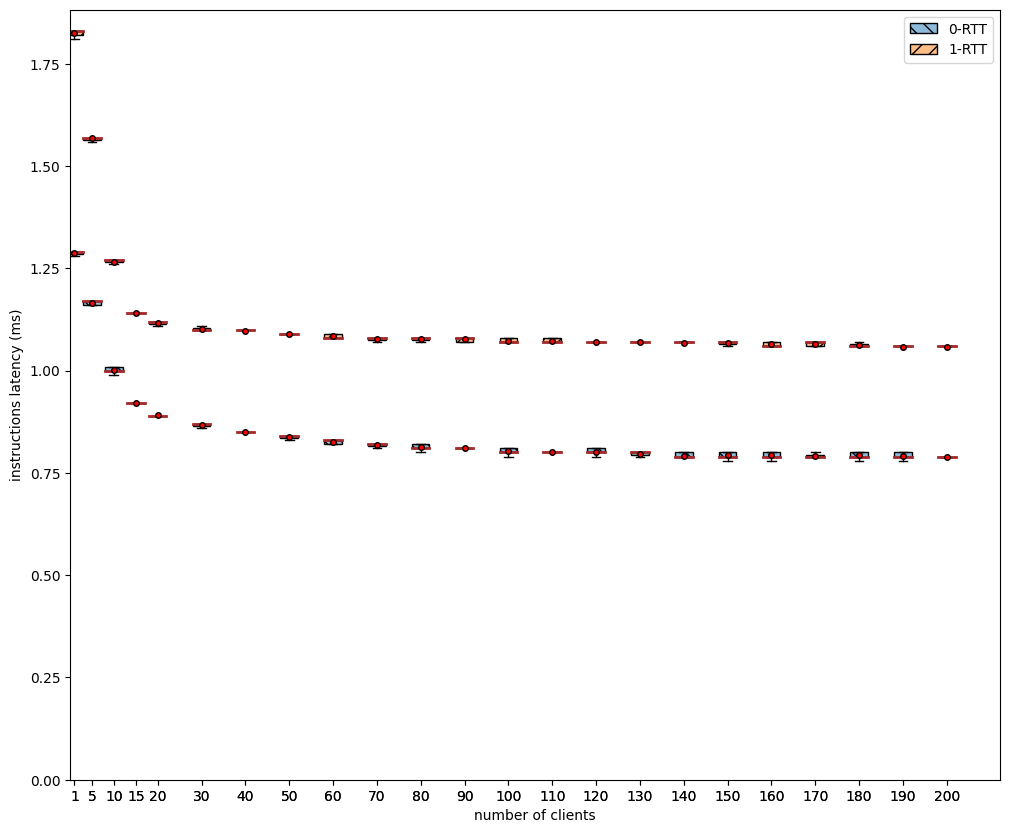

Reading file perf-data/perf-v2-parallel-I13-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I13-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I14-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P5-C0_rtt-server.data
Reading fi

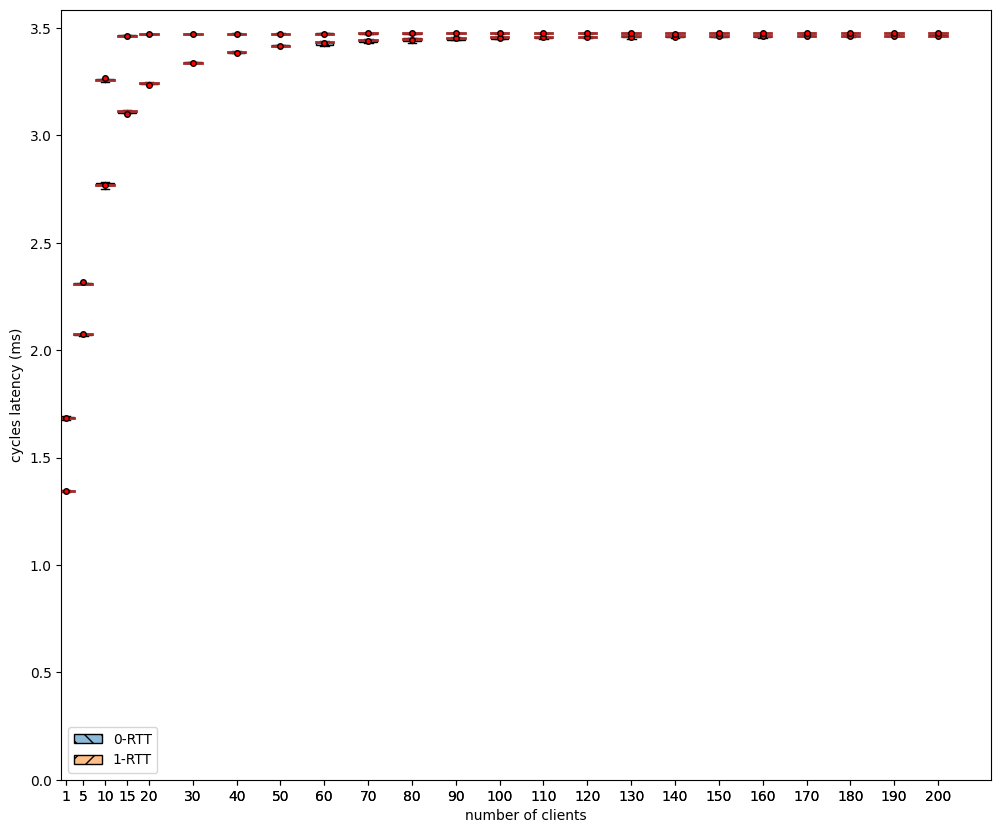

Reading file perf-data/perf-v2-parallel-I13-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I13-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I14-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P5-C0_rtt-server.data
Reading fi

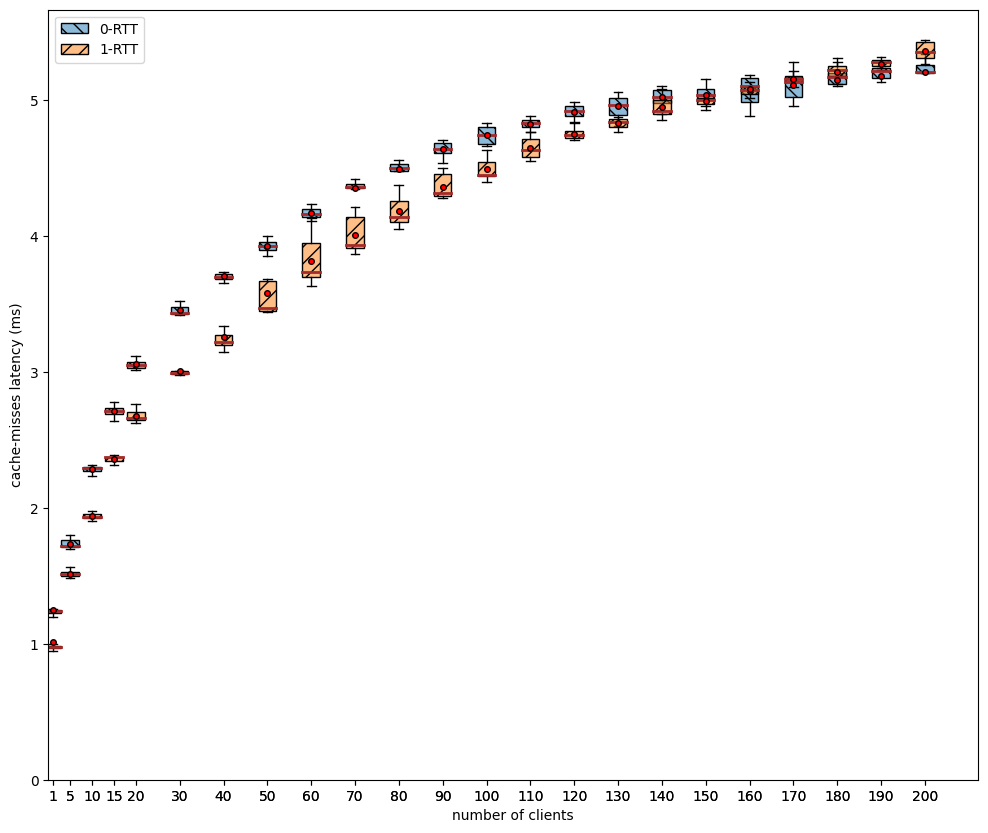

Reading file perf-data/perf-v2-parallel-I13-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I13-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I14-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P5-C0_rtt-server.data
Reading fi

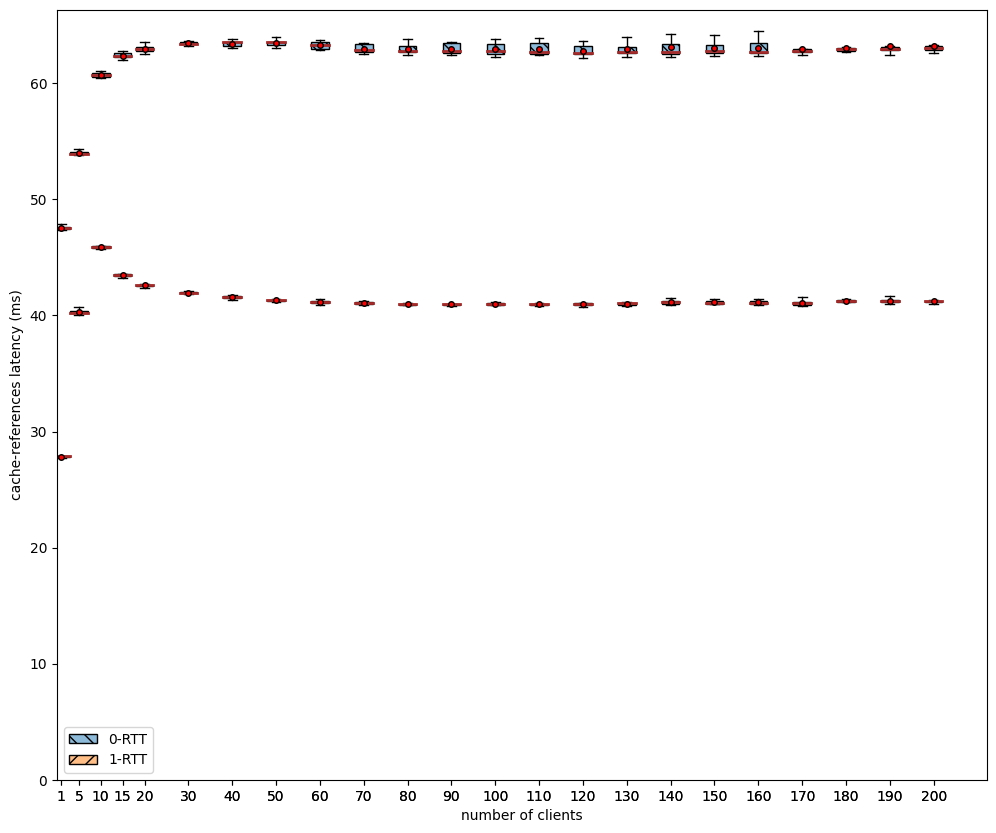

Reading file perf-data/perf-v2-parallel-I13-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I13-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I14-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P5-C0_rtt-server.data
Reading fi

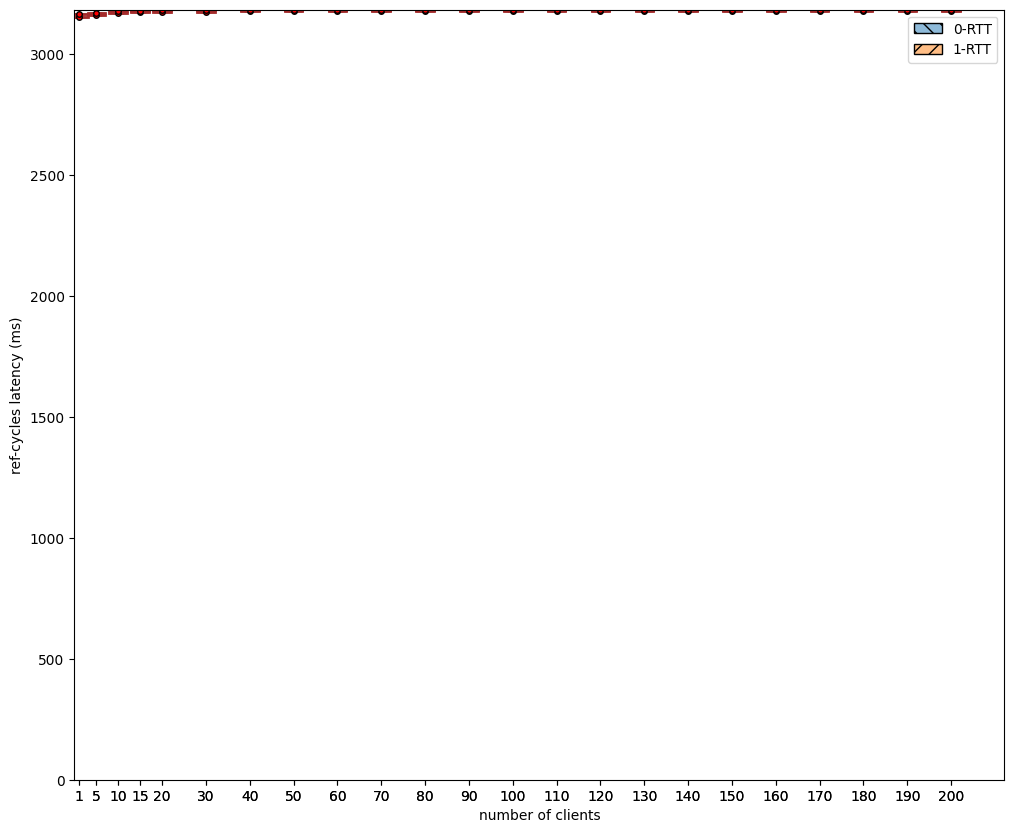

Reading file perf-data/perf-v2-parallel-I13-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I13-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I14-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P5-C0_rtt-server.data
Reading fi

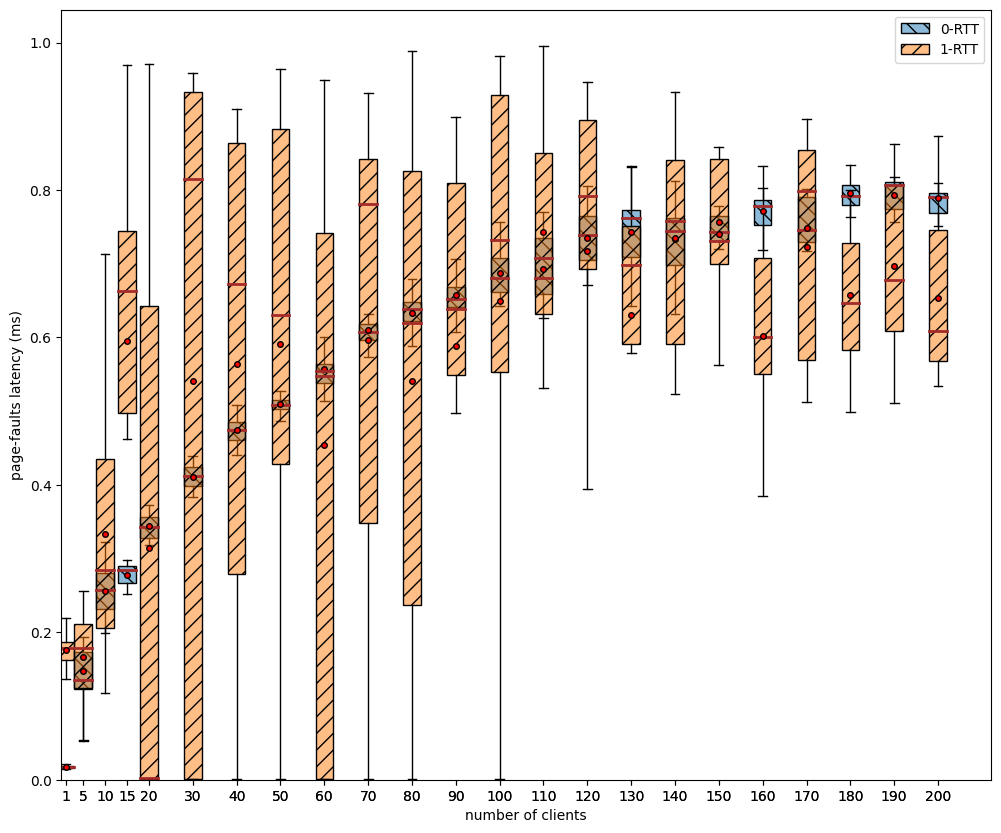

Reading file perf-data/perf-v2-parallel-I13-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I13-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I14-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I15-P5-C0_rtt-server.data
Reading file perf-data/perf-v2-parallel-I16-P5-C0_rtt-server.data
Reading fi

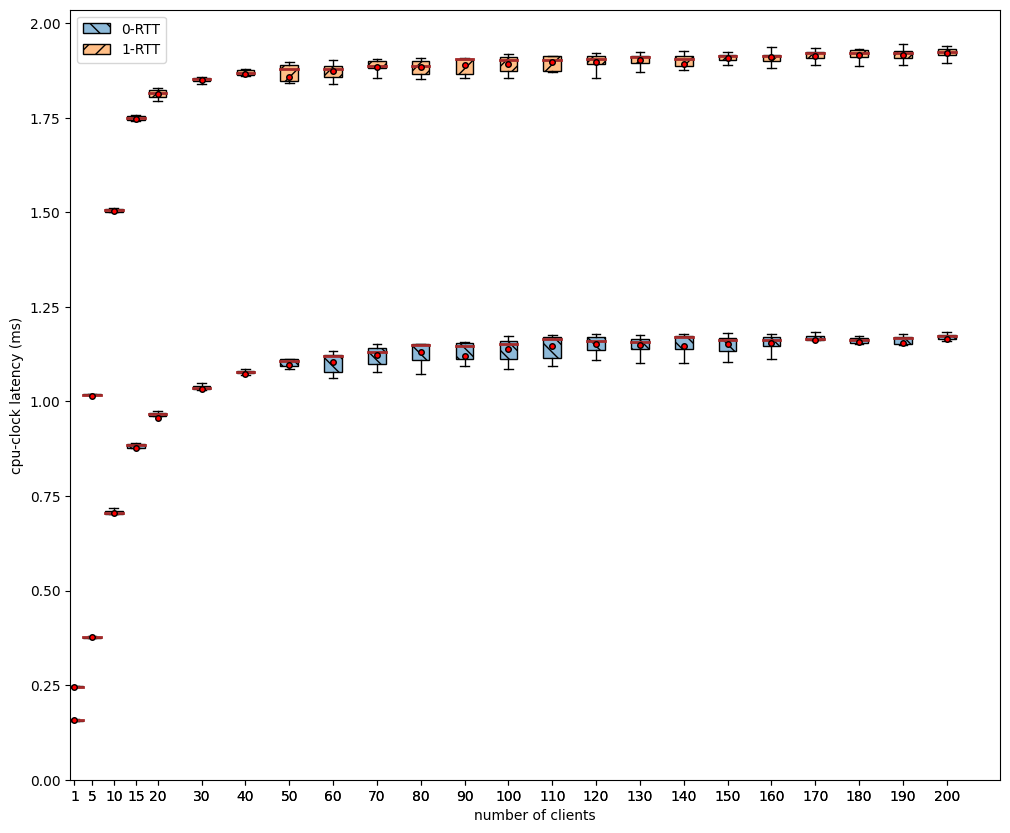

Reading file perf-data/perf-v2-parallel-I13-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I13-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I14-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P5-C0_rtt.da

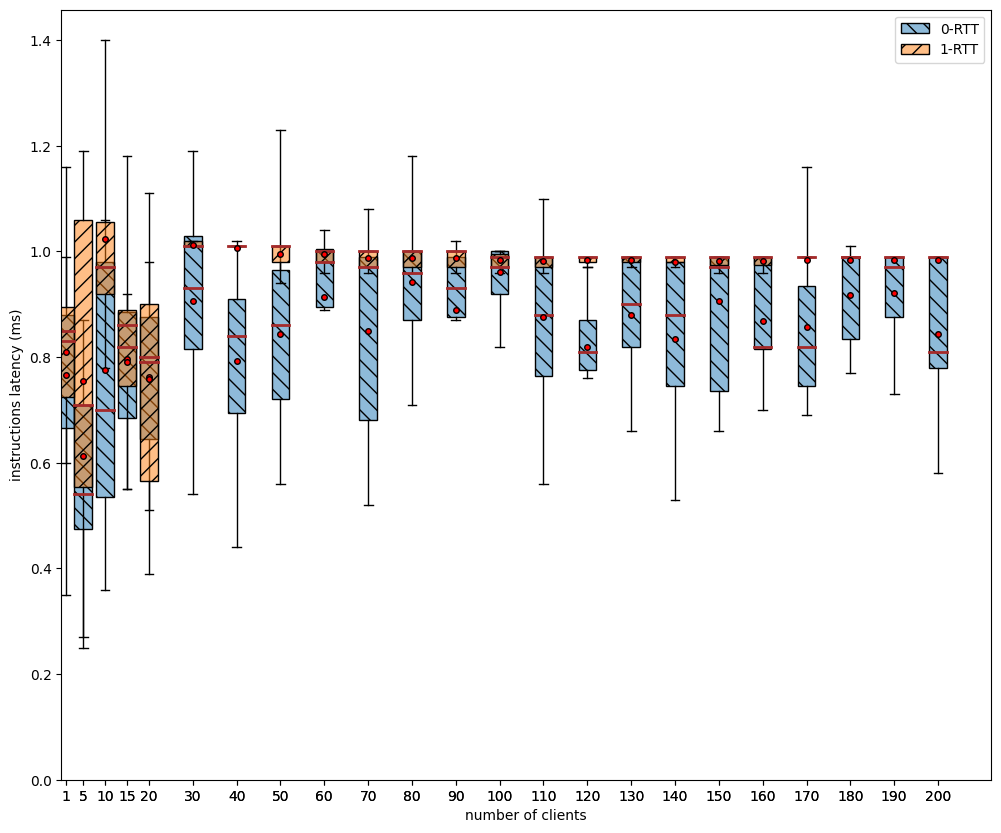

Reading file perf-data/perf-v2-parallel-I13-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I13-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I14-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P5-C0_rtt.da

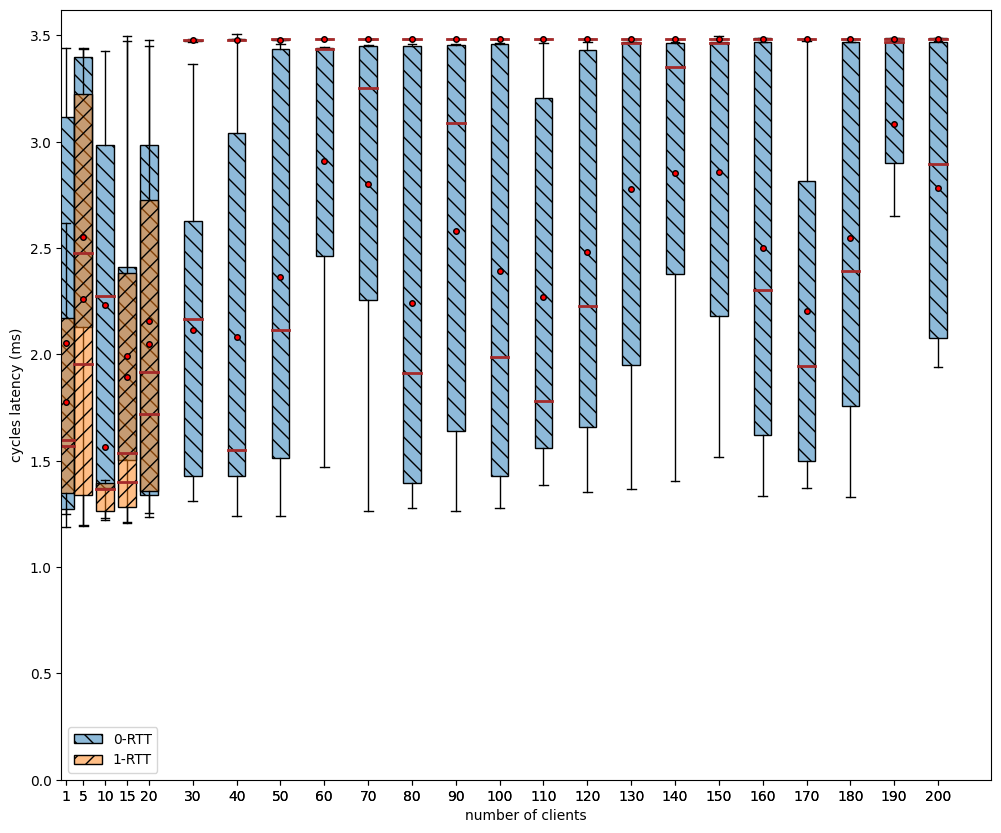

Reading file perf-data/perf-v2-parallel-I13-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I13-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I14-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P5-C0_rtt.da

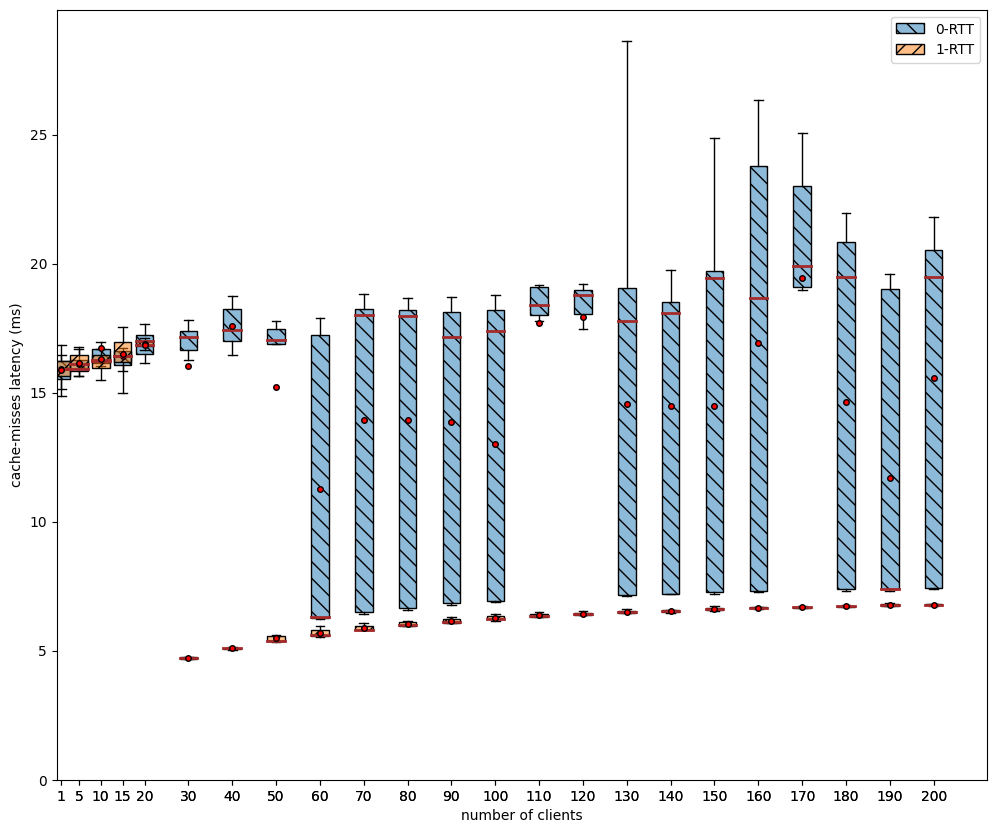

Reading file perf-data/perf-v2-parallel-I13-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I13-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I14-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P5-C0_rtt.da

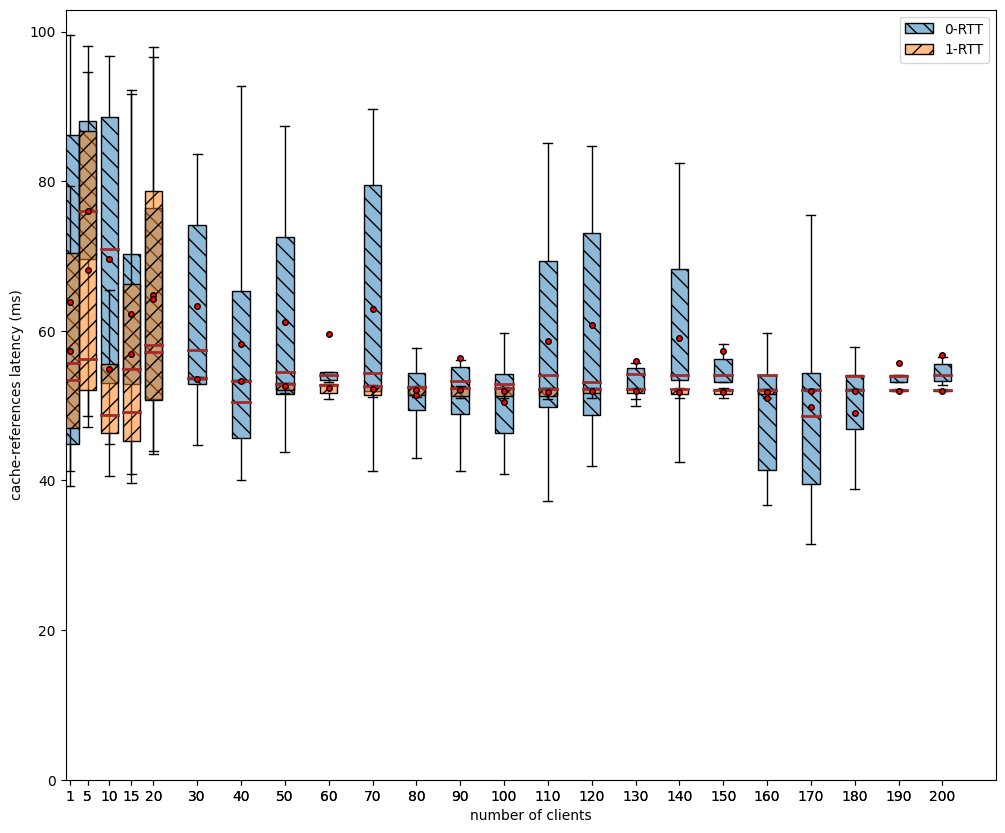

Reading file perf-data/perf-v2-parallel-I13-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I13-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I14-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P5-C0_rtt.da

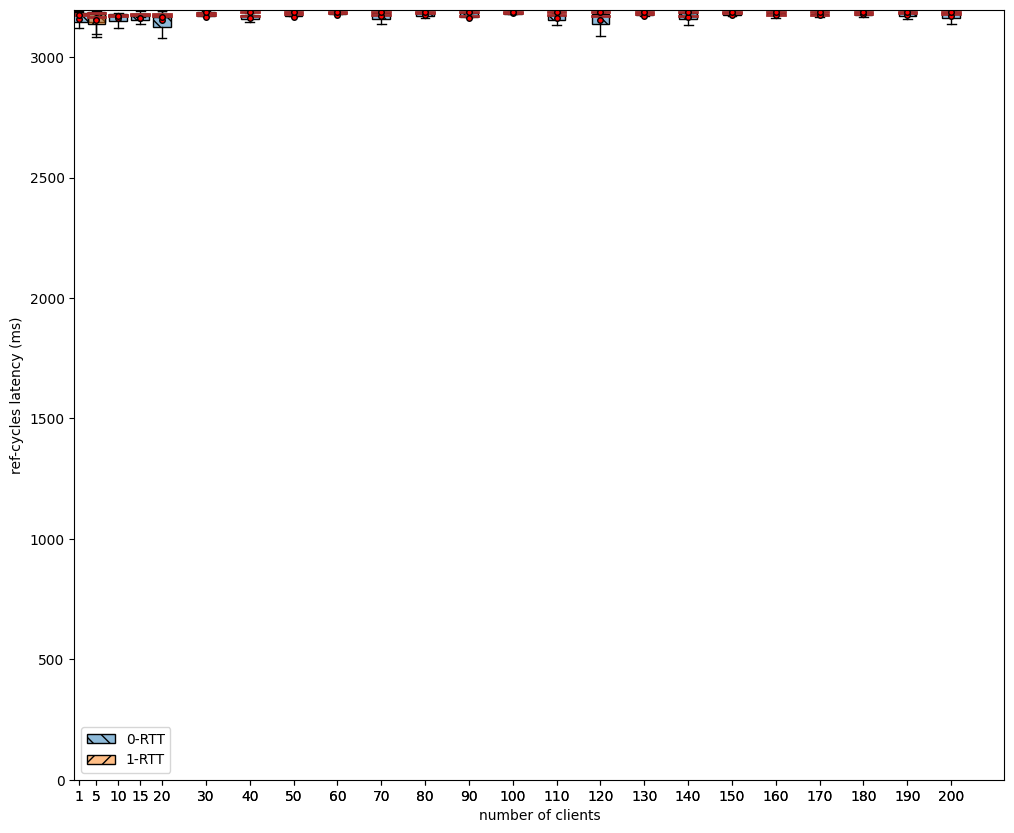

Reading file perf-data/perf-v2-parallel-I13-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I13-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I14-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P5-C0_rtt.da

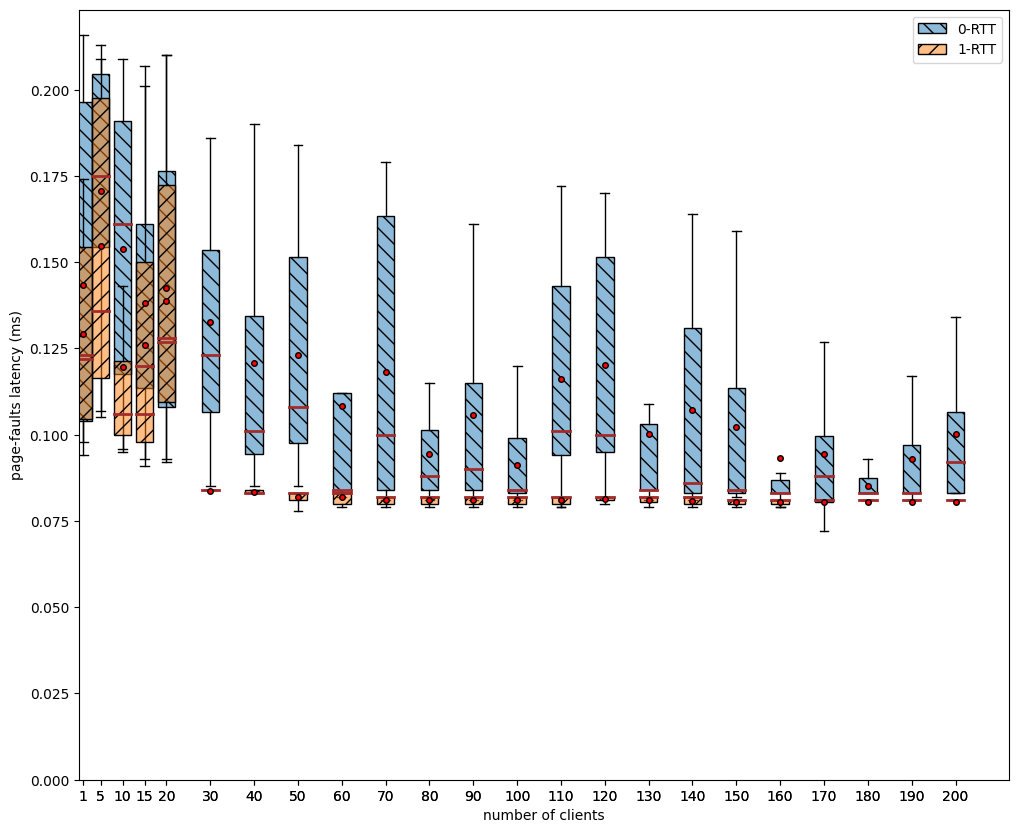

Reading file perf-data/perf-v2-parallel-I13-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I14-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I19-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I20-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I21-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I22-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I23-P1-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I13-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I14-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I15-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I16-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I17-P5-C0_rtt.data
Reading file perf-data/perf-v2-parallel-I18-P5-C0_rtt.da

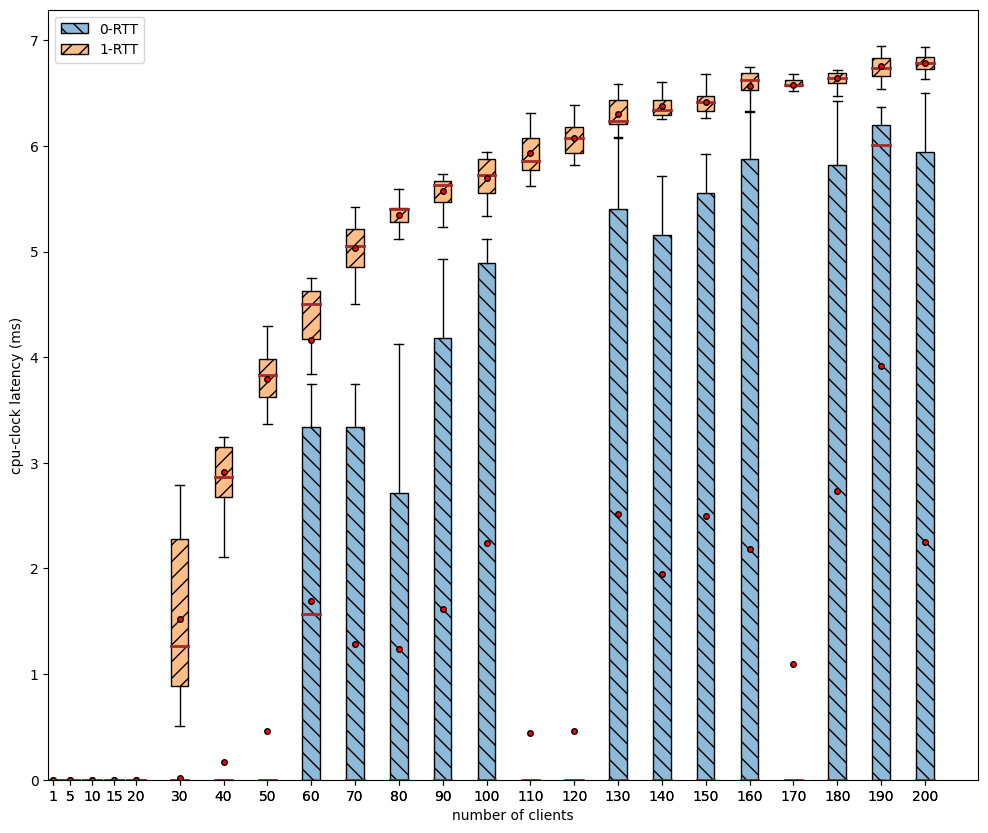

In [98]:
plot_combined()